# Introduction.
The following is an implementation of the ideas in the following [paper](https://arxiv.org/abs/2505.08795). Important insights from this paper include
> We show that there is a fast algorithm that embeds hierarchical structures in three-dimensional Minkowski spacetime $(x,y,z,time)$

> We apply our method to the corpus of WordNet. We provide a perfect embedding of the mammal sub-tree including ambiguities (more than one hierarchy per node) in such a way that the hierarchical structures get completely codified in the geometry and exactly reproduce the ground-truth.

And most profoundly,
> We introduce a novel retrieval mechanism in which causality, not distance,
governs hierarchical access. Our results seem to indicate that all discrete data has a perfect geometrical representation that is three-dimensional. These results suggest that concepts, categories, and their interrelations, namely hierarchical meaning itself, is geometric.

# Methods
The paper uses relativly simple updates by mapping points on a DAG (Directed Acryllic Graph) to points in Minkowski Spacetime $(x,y,z,time)$. It then takes a $(parent, child)$ pair of these points and shows that by preforming simple updates of $tX → tX + δ(1 − ϵ2)$  and $tY → tY − δϵ2$ Where $X$ is the child of the parent $Y$ until the updates no longer $violations = T_{XY} ≤ 0 ∪ T_{XY} < D_{XY}$ where $D_{XY}$ is the standard Eucludean distance between the two points, the $(parent, child)$ pair of nodes converge to the minimal possible distance between the two points $T_{min} = D_{XY} + ϵ1$ and $δ = T_{min} − T_{XY}$
This means that the smallest distance (near zero) between the two points in Minkowski Spacetime converge to their semantic meaning in $O(1)$ time complexity.
I demonstrate that this relation holds true on simple Tree structures, Directed Graphs like git commits, and even in Pre-Trained Transformers such as BERT which represent data in a much higher dimension (786D).
The results are very visualizable.
# Conclusions.
The results, if they hold true under the conditions are profound. Imagine being able to ask "X isA Y?" and know the answer in constant time. The results of such an algorithm could easily be applied to various scenerios.
If information in its optimal representation is causally related then.
> Our experiments show that the representation is optimal when
the geodesics within the representation are almost null, resulting in an almost conformally invariant embedding.
# References.
[paper](https://arxiv.org/abs/2505.08795)





In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch  # Import torch
import time

# @title Define a Simple Tree Structure
edges = [
    ("Root", "A"),
    ("Root", "B"),
    ("Root", "C"),
    ("Root", "Q"),
    ("B", "Q"),
    ("A", "Q"),
    ("A", "D"),
    ("A", "E"),
    ("C", "F"),
]

G = nx.DiGraph(edges)
root = [n for n, d in G.in_degree() if d == 0][0]

print(f"Tree structure with root: {root}")
print(f"Nodes: {list(G.nodes())}")
print(f"Edges: {list(G.edges())}")

# Create mapping from node name to index
all_nodes = list(G.nodes())
num_nodes = len(all_nodes)
node_to_idx = {node: i for i, node in enumerate(all_nodes)}

# Create pairs tensor [child_idx, parent_idx]
# The provided function expects this order
pairs_list = []
for parent, child in G.edges():
    pairs_list.append([node_to_idx[child], node_to_idx[parent]])

pairs_tensor = torch.LongTensor(pairs_list)

print(f"\nPairs Tensor (child_idx, parent_idx):\n{pairs_tensor}")

Tree structure with root: Root
Nodes: ['Root', 'A', 'B', 'C', 'Q', 'D', 'E', 'F']
Edges: [('Root', 'A'), ('Root', 'B'), ('Root', 'C'), ('Root', 'Q'), ('A', 'Q'), ('A', 'D'), ('A', 'E'), ('B', 'Q'), ('C', 'F')]

Pairs Tensor (child_idx, parent_idx):
tensor([[1, 0],
        [2, 0],
        [3, 0],
        [4, 0],
        [4, 1],
        [5, 1],
        [6, 1],
        [4, 2],
        [7, 3]])


In [ ]:
# @title Assign Initial Spacetime-like Coordinates (t, X)

# We'll use depth as the initial 'time' coordinate (t)
# We'll use random 2D coordinates for the 'space' (X)
# Total dimensions = 1 time + 2 space = 3D embedding for visualization
initial_spatial = np.random.rand(num_nodes, 2) * 10  # Random 2D spatial coordinates
node_depths = nx.shortest_path_length(G, source=root)
initial_time = np.zeros(num_nodes)

for node, depth in node_depths.items():
    idx = node_to_idx[node]
    initial_time[idx] = depth  # Assign depth to the 't' coordinate

# Convert to PyTorch tensors
spatial_tensor = torch.Tensor(initial_spatial)
time_vec_tensor = torch.Tensor(initial_time)  # time_vec is a 1D tensor

print("\nInitial Coordinates (first 5 nodes):")
for i in range(min(5, num_nodes)):
    node = all_nodes[i]
    coords = spatial_tensor[i, :].tolist() + [time_vec_tensor[i].item()]
    print(f"Node '{node}': (X1={coords[0]:.2f}, X2={coords[1]:.2f}, t={coords[2]:.2f})")

# Combine for initial visualization
initial_combined_coords = torch.cat(
    [spatial_tensor, time_vec_tensor.unsqueeze(1)], dim=1
).numpy()


Initial Coordinates (first 5 nodes):
Node 'Root': (X1=5.60, X2=4.79, t=0.00)
Node 'A': (X1=1.88, X2=0.77, t=1.00)
Node 'B': (X1=8.64, X2=3.91, t=1.00)
Node 'C': (X1=1.44, X2=8.21, t=1.00)
Node 'Q': (X1=4.51, X2=7.89, t=1.00)


In [ ]:
# @title Visualization Function
def plot_embedding(coords_np, title, node_labels, edges_list, node_to_idx_map):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    # Plot nodes as scatter points (X1, X2, t) -> (x, y, z)
    ax.scatter(coords_np[:, 0], coords_np[:, 1], coords_np[:, 2], s=100)

    # Plot edges (lines between parent and child)
    for parent, child in edges_list:
        p_idx = node_to_idx_map[parent]
        c_idx = node_to_idx_map[child]
        ax.plot(
            coords_np[[p_idx, c_idx], 0],
            coords_np[[p_idx, c_idx], 1],
            coords_np[[p_idx, c_idx], 2],
            "gray",
            linestyle="-",
            linewidth=1,
        )

    # Label points
    for node, idx in node_to_idx_map.items():
        ax.text(
            coords_np[idx, 0],
            coords_np[idx, 1],
            coords_np[idx, 2],
            node,
            color="black",
            fontsize=12,
            ha="right",
        )

    ax.set_xlabel("Spatial Dimension X1")
    ax.set_ylabel("Spatial Dimension X2")
    ax.set_zlabel("Time (Depth)")
    ax.set_title(title)

    # Adjust aspect ratio / limits
    max_range = (
        np.array(
            [
                coords_np[:, 0].max() - coords_np[:, 0].min(),
                coords_np[:, 1].max() - coords_np[:, 1].min(),
                coords_np[:, 2].max() - coords_np[:, 2].min(),
            ]
        ).max()
        / 2.0
    )
    mid_x = (coords_np[:, 0].max() + coords_np[:, 0].min()) * 0.5
    mid_y = (coords_np[:, 1].max() + coords_np[:, 1].min()) * 0.5
    mid_z = (coords_np[:, 2].max() + coords_np[:, 2].min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    plt.show()

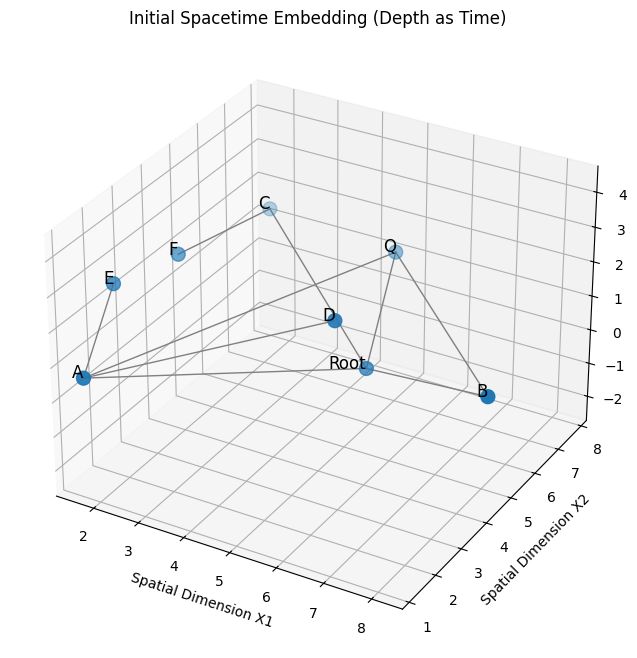

In [ ]:
# @title Visualize Initial State
plot_embedding(
    initial_combined_coords,
    "Initial Spacetime Embedding (Depth as Time)",
    all_nodes,
    edges,
    node_to_idx,
)

In [ ]:
# @title Provided Convergence Function (Enforcing Δt > ||Δx||)
def project_until_convergence(
    pairs: torch.LongTensor,
    spatial: torch.Tensor,  # spatial coordinates (fixed in this projection)
    time_vec: torch.Tensor,  # time coordinate (this is modified)
    eps1: float = 1e-5,  # small epsilon for strict inequality
    eps2: float = 0.0,  # parameter from old code, not used in new part
    max_passes: int = 5000,
) -> int:
    """Deterministically enforce `Δt > ||Δx||` by shifting *only* `t`.

    Modifies time_vec in place.

    Returns the number of full passes executed until convergence.
    """
    # Ensure tensors are on the same device if using GPU, though Colab default is CPU
    # pairs = pairs.to(time_vec.device)
    # spatial = spatial.to(time_vec.device)
    for n_pass in range(1, max_passes + 1):
        c = pairs[:, 0]  # child indices
        p = pairs[:, 1]  # parent indices

        # Calculate spatial distance and temporal difference for each pair
        delta_space = (spatial[c] - spatial[p]).norm(dim=1)  # ||Δx||
        delta_t = time_vec[c] - time_vec[p]  # Δt = t_child - t_parent

        # Identify violations: child's time is not strictly greater than parent's OR
        # time separation is not strictly greater than spatial distance (Δt <= ||Δx||)
        violation_temporal_order = delta_t <= 0
        violation_spacetime_constraint = delta_t <= delta_space
        violation = violation_temporal_order | violation_spacetime_constraint

        if not violation.any():
            print(f"Converged after {n_pass} passes.")
            return n_pass  # converged!

        # Calculate the shift needed for the violating pairs
        # needed_shift = amount to add to delta_t to satisfy delta_t > delta_space + eps1
        needed_shift = delta_space[violation] + eps1 - delta_t[violation]

        # Get the child and parent indices for the violating pairs
        c_bad = c[violation]
        p_bad = p[violation]

        # ▶▶ new – split δ across *every* parent of the child ───────────────
        # This part handles cases where a child might have multiple parents
        # causing violations in the current pass. It distributes the shift
        # needed by that child across all its parents involved in violations
        # within this specific batch of violating pairs.

        # Count how many times each *child* index appears in the c_bad tensor
        # (i.e., how many violating parents each child has in this pass)
        # Use minlength to ensure size matches total number of nodes
        counts = torch.bincount(c_bad, minlength=time_vec.size(0))[c_bad]

        # Calculate the share of the needed shift per violating parent link
        # This share is added to the child's time and subtracted from the parent's time
        share = needed_shift / counts.float()  # Use float() division

        # Apply the updates:
        # Add the share to the time of the children involved in violations
        time_vec.index_add_(0, c_bad, share)

        # Subtract the share from the time of the parents involved in violations
        time_vec.index_add_(0, p_bad, -share)
        # ────────────────────────────────────────────────────────────────────

        # Optional: Print progress periodically
        if n_pass % 100 == 0:
            print(f"Pass {n_pass}: {violation.sum().item()} violations remaining.")

    print(f"Did not converge after {max_passes} passes.")

    return (
        max_passes + 1
    )  # did *not* converge (should not happen in theory if structure allows)

In [ ]:
# @title Run the Convergence Process

# Make copies of the tensors as the function modifies time_vec in place
spatial_tensor_converged = spatial_tensor.clone()
time_vec_tensor_converged = time_vec_tensor.clone()

print("\nRunning convergence function...")
start_time = time.time()
print(f"Starting Convergence at time t={start_time}")
passes_taken = project_until_convergence(
    pairs_tensor, spatial_tensor_converged, time_vec_tensor_converged, max_passes=10000
)  # Increased max_passes
end_time = time.time()
print(f"Convergence took {end_time - start_time} seconds.")
print(f"Convergence process finished. Passes: {passes_taken}")

# Combine for visualization
converged_combined_coords = torch.cat(
    [spatial_tensor_converged, time_vec_tensor_converged.unsqueeze(1)], dim=1
).numpy()


Running convergence function...
Starting Convergence at time t=1748023556.1390245
Converged after 3 passes.
Convergence took 0.05466938018798828 seconds.
Convergence process finished. Passes: 3


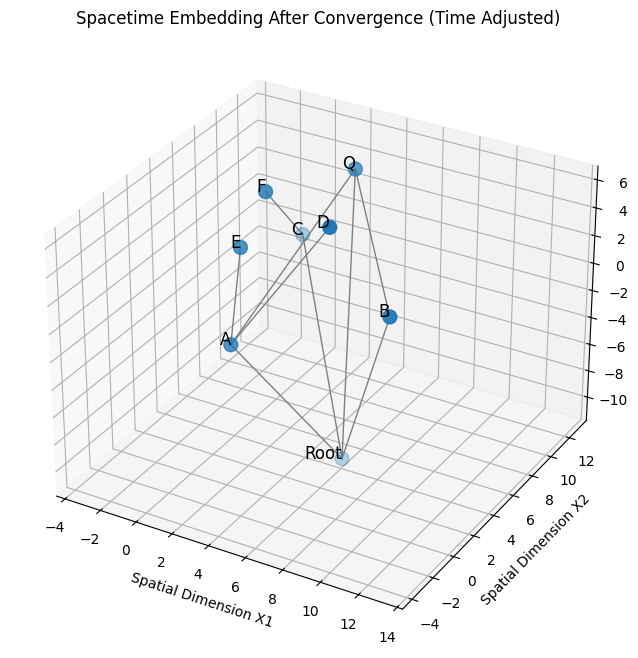

In [ ]:
# @title Visualize Converged State
plot_embedding(
    converged_combined_coords,
    "Spacetime Embedding After Convergence (Time Adjusted)",
    all_nodes,
    edges,
    node_to_idx,
)

In [ ]:
# @title Explore Spacetime Interval (Post-Convergence Example)
print("\nExploring Spacetime Intervals (post-convergence):")


def calculate_delta_s_squared_np(coords1_np, coords2_np):
    delta_t = coords1_np[2] - coords2_np[2]  # Time (Depth) difference
    delta_x = coords1_np[:2] - coords2_np[:2]  # Spatial difference vector
    spatial_distance_squared = np.sum(delta_x**2)  # Euclidean spatial distance squared
    delta_s_squared = -(delta_t**2) + spatial_distance_squared
    return delta_s_squared


# Example Pairs (using numpy arrays from the final visualization coords)
# Note: Check pairs ensuring the first node is later or at the same time as the second
pairs_to_check = [
    ("Q", "B"),
    ("Q", "Root"),  # Grandparent -> Grandchild (should be valid relationship
    ("Q", "A"),  # Grandparent -> Parent (should be valid relationship)
    ("D", "A"),  # Child -> Parent (should be valid relationship)
    ("A", "Root"),  # Child -> Parent
    ("F", "C"),  # Child -> Parent
    ("D", "Root"),  # Grandchild -> Grandparent
    ("F", "Root"),  # Grandchild -> Grandparent
    ("D", "C"),  # Sibling's child -> Sibling (unrelated)
    ("F", "A"),  # Sibling's child -> Sibling (unrelated)
    ("A", "B"),  # Siblings
]

converged_coords_np_dict = {
    all_nodes[i]: converged_combined_coords[i, :] for i in range(num_nodes)
}


for node1_name, node2_name in pairs_to_check:
    if (
        node1_name in converged_coords_np_dict
        and node2_name in converged_coords_np_dict
    ):
        coords1_np = converged_coords_np_dict[node1_name]
        coords2_np = converged_coords_np_dict[node2_name]

        # Ensure node1 is later or at same time as node2 for delta_t calculation
        # (Delta t = t1 - t2)
        is_later = coords1_np[2] >= coords2_np[2]
        if not is_later:
            # For relationship analysis (like causality), order matters.
            # If node1 is *earlier* than node2, it cannot be a descendant
            # For simply calculating ds2, order doesn't matter as much for (dt)^2
            # but the violation check is (t_child - t_parent) > ||dx||
            pass  # Keep original order if checking relationship flow
        # Or swap for calculation if just comparing |dt| vs ||dx||
        # coords1_np, coords2_np = coords2_np, coords1_np
        # node1_name, node2_name = node2_name, node1_name
        # is_later = True # Treat as if ordered for calculation

        ds2 = calculate_delta_s_squared_np(coords1_np, coords2_np)
        proper_time_squared_analogue = -ds2

        # Check the paper's *enforced* condition for parent-child pairs: Delta_t > ||Delta_x||
        # Re-calculate for the specific pair order
        delta_t_ordered = coords1_np[2] - coords2_np[2]
        delta_space_ordered = np.linalg.norm(coords1_np[:2] - coords2_np[:2])
        meets_enforced_condition = delta_t_ordered > delta_space_ordered

        # Check if the second node (potential ancestor) is in the first node's (potential descendant's) past light cone
        # Condition: ds^2 <= 0 AND t_descendant >= t_ancestor
        in_past_light_cone = ds2 <= 0 and is_later

        print(f"Pair ('{node1_name}', '{node2_name}'):")
        print(
            f"  t ({node1_name})={coords1_np[2]:.2f}, t ({node2_name})={coords2_np[2]:.2f}"
        )
        print(f"  Spatial Dist: {delta_space_ordered:.2f}")
        print(f"  Delta t ({node1_name}-{node2_name}): {delta_t_ordered:.2f}")
        print(f"  Delta s^2: {ds2:.2f}")
        print(
            f"  -Delta s^2 (Proper Time Sq Analogue): {proper_time_squared_analogue:.2f}"
        )
        print(
            f"  Meets Enforced Condition (Δt > ||Δx||)? {meets_enforced_condition}"
        )  # Enforced for parent-child
        print(
            f"  '{node2_name}' in '{node1_name}'s Past Light Cone (Δs^2 <= 0 & t1 >= t2)? {in_past_light_cone}"
        )  # General check
        print("-" * 20)


Exploring Spacetime Intervals (post-convergence):
Pair ('Q', 'B'):
  t (Q)=6.98, t (B)=0.47
  Spatial Dist: 5.73
  Delta t (Q-B): 6.51
  Delta s^2: -9.51
  -Delta s^2 (Proper Time Sq Analogue): 9.51
  Meets Enforced Condition (Δt > ||Δx||)? True
  'B' in 'Q's Past Light Cone (Δs^2 <= 0 & t1 >= t2)? True
--------------------
Pair ('Q', 'Root'):
  t (Q)=6.98, t (Root)=-11.79
  Spatial Dist: 3.28
  Delta t (Q-Root): 18.77
  Delta s^2: -341.42
  -Delta s^2 (Proper Time Sq Analogue): 341.42
  Meets Enforced Condition (Δt > ||Δx||)? True
  'Root' in 'Q's Past Light Cone (Δs^2 <= 0 & t1 >= t2)? True
--------------------
Pair ('Q', 'A'):
  t (Q)=6.98, t (A)=-2.03
  Spatial Dist: 7.59
  Delta t (Q-A): 9.01
  Delta s^2: -23.53
  -Delta s^2 (Proper Time Sq Analogue): 23.53
  Meets Enforced Condition (Δt > ||Δx||)? True
  'A' in 'Q's Past Light Cone (Δs^2 <= 0 & t1 >= t2)? True
--------------------
Pair ('D', 'A'):
  t (D)=5.70, t (A)=-2.03
  Spatial Dist: 4.70
  Delta t (D-A): 7.73
  Delta s^2: 

# Application: WordNet Embeddings
Using the example from the paper, we can embed (Parent, Child) relationships from WordNet to test our theory on a DAG! We can also show that pre-trained Encoders like BERT also already understand this relationship as well!

The first thing we will do is compare the Minkowski embedding to BERT embedding!

=== Minkowski Embedding Demo with LLM-Generated Function ===

Computing Minkowski Embedding...

--- Computed Minkowski Coordinates (t, x, y) ---
entity: [0.000, 0.821, 0.491]
animal: [1.937, -0.895, -0.406]
mammal: [2.198, -0.710, -0.223]
canine: [3.602, 0.652, -0.566]
dog: [3.723, 0.614, -0.452]
cat: [3.214, -0.182, 0.581]
feline: [3.096, -0.300, 0.576]

--- Causal Consistency Check ---
Link: entity -> animal : Consistent
Link: animal -> mammal : Consistent
Link: mammal -> canine : Consistent
Link: canine -> dog : Consistent
Link: mammal -> feline : Consistent
Link: feline -> cat : Consistent
All checked causal constraints appear to be met by the LLM's function!


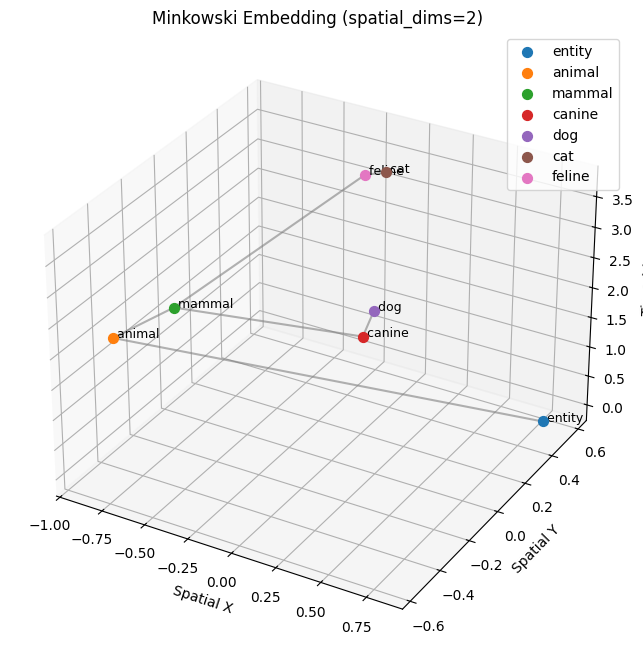

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from collections import defaultdict


# --- LLM-Generated Function (Copied from your input) ---
def compute_minkowski_embedding(
    concept_bert_embeddings: dict[str, list[float]],
    hierarchy_pairs: list[tuple[str, str | None]],
    spatial_dims: int,
    epsilon_causal_margin: float,
) -> dict[str, list[float]]:
    """
    Computes Minkowski spacetime coordinates for concepts based on BERT embeddings
    and a hierarchy, ensuring causal consistency.
    """
    concept_names = list(concept_bert_embeddings.keys())
    if not concept_names:
        return {}

    bert_matrix = np.array([concept_bert_embeddings[name] for name in concept_names])
    num_concepts = bert_matrix.shape[0]

    if bert_matrix.size == 0:  # No data in bert_matrix
        print("Warning: BERT matrix is empty. Returning empty coords.")
        return (
            {name: [0.0] * (1 + spatial_dims) for name in concept_names}
            if concept_names
            else {}
        )

    bert_dim = bert_matrix.shape[1]
    coords = {}

    # 1. Initial Spatial Embedding (using PCA) ========
    if spatial_dims > 0:
        # PCA requires n_samples >= n_features if n_features > n_components
        # and n_samples > n_components
        n_components_pca = min(
            spatial_dims, bert_dim, num_concepts - 1 if num_concepts > 1 else 1
        )  # Ensure n_components < n_samples
        spatial_coords_matrix = np.zeros((num_concepts, spatial_dims))
        if num_concepts > 1 and n_components_pca > 0 and bert_dim > 0:
            try:
                pca = PCA(n_components=n_components_pca)
                spatial_coords_pca = pca.fit_transform(bert_matrix)
                spatial_coords_matrix[:, :n_components_pca] = spatial_coords_pca
            except ValueError as e:
                print(f"Warning: PCA failed: {e}. Using zeros for spatial coordinates.")
        elif num_concepts == 1 and n_components_pca > 0 and bert_dim > 0:
            # PCA not meaningful for a single point, place at origin or use part of its BERT
            spatial_coords_matrix[:, : min(spatial_dims, bert_dim)] = bert_matrix[
                0, : min(spatial_dims, bert_dim)
            ]
        for i, name in enumerate(concept_names):
            coords[name] = [0.0] + spatial_coords_matrix[i].tolist()
    else:
        for name in concept_names:
            coords[name] = [0.0]
    # 2. Build Parent-Child Graph and Identify Roots =======
    parent_to_children = defaultdict(list)
    child_to_parents = defaultdict(list)
    explicit_root_children = set()

    for child_name, parent_name in hierarchy_pairs:
        if parent_name is not None:
            if parent_name in concept_names and child_name in concept_names:
                parent_to_children[parent_name].append(child_name)
                child_to_parents[child_name].append(parent_name)
        else:
            if child_name in concept_names:
                explicit_root_children.add(child_name)

    if not explicit_root_children:
        all_children_in_set = {
            c
            for c, p in hierarchy_pairs
            if p is not None and p in concept_names and c in concept_names
        }
        root_nodes = [name for name in concept_names if name not in all_children_in_set]
    else:
        root_nodes = list(explicit_root_children)

    if not root_nodes and concept_names:
        print(
            "Warning: No explicit or implicit roots found. Using first concept as a pseudo-root for time normalization."
        )
        root_nodes = [concept_names[0]]

    # 3. Iterative Time Adjustment (Relaxation) ========
    max_iterations = 1000
    learning_rate_adjustment = 0.1  # Added for potentially smoother adjustments
    # This is the tiny_buffer to satisfy strict inequality discussed
    strict_inequality_buffer = epsilon_causal_margin * 0.01 + 1e-9

    for iteration in range(max_iterations):
        changed_in_iteration = False
        for child_name, parent_name in hierarchy_pairs:
            if parent_name is None:
                continue
            if parent_name not in coords or child_name not in coords:
                continue

            p_coords = coords[parent_name]
            c_coords = coords[child_name]

            if spatial_dims > 0:
                spatial_dist_sq = np.sum(
                    (np.array(c_coords[1:]) - np.array(p_coords[1:])) ** 2
                )
            else:
                spatial_dist_sq = 0

            # Ensure argument to sqrt is non-negative
            sqrt_arg = spatial_dist_sq + epsilon_causal_margin
            if sqrt_arg < 0:
                sqrt_arg = 0  # Should not happen with positive epsilon

            required_dt = np.sqrt(sqrt_arg)
            # Apply the strict inequality buffer here:
            required_t_c = p_coords[0] + required_dt + strict_inequality_buffer

            if c_coords[0] < required_t_c:
                # Apply with a learning rate to prevent wild oscillations if hierarchy is complex
                diff = required_t_c - c_coords[0]
                coords[child_name][0] += diff * learning_rate_adjustment
                changed_in_iteration = True
        if not changed_in_iteration and iteration > 0:
            print(f"Converged at iteration {iteration}")
            break

    # 4. Shift times so the minimum root time is 0  =======
    if root_nodes and all(name in coords for name in root_nodes):
        min_t = min(coords[name][0] for name in root_nodes)
    elif coords:
        min_t = min(c[0] for c in coords.values())
    else:
        min_t = 0.0

    for name in coords:
        coords[name][0] -= min_t
        # Ensure no negative times due to floating point issues after shift
        if coords[name][0] < 0 and abs(coords[name][0]) < 1e-9:  # if very close to 0
            coords[name][0] = 0.0

    return coords


# --- Helper Functions for Evaluation ---
def spatial_distance_sq_eval(
    coord1_spatial: list[float], coord2_spatial: list[float]
) -> float:
    return np.sum((np.array(coord1_spatial) - np.array(coord2_spatial)) ** 2)


def check_causal_link_eval(
    child_coord_minkowski: list[float],
    parent_coord_minkowski: list[float],
    epsilon_causal_margin: float,
    spatial_dims: int,
) -> bool:
    """
    Checks if child time is strictly greater than parent time + spatial distance.
    """
    if (
        len(child_coord_minkowski) != 1 + spatial_dims
        or len(parent_coord_minkowski) != 1 + spatial_dims
    ):
        return False  # Invalid input format

    dt = child_coord_minkowski[0] - parent_coord_minkowski[0]
    # For strict inequality in causal link, dt MUST be > 0.
    if dt <= 1e-9:  # dt must be positive by more than just float noise
        return False
    d_spatial_sq_val = spatial_distance_sq_eval(
        child_coord_minkowski[1:], parent_coord_minkowski[1:]
    )
    # Check for strict inequality: dt^2 > d_spatial_sq + epsilon
    return dt**2 > d_spatial_sq_val + epsilon_causal_margin


print("=== Minkowski Embedding Demo with LLM-Generated Function ===")

# 1. Define Concepts and Dummy BERT Embeddings
# Let's use a simple animal hierarchy
concept_names_demo = ["entity", "animal", "mammal", "canine", "dog", "cat", "feline"]
bert_dim_demo = 16  # Smaller dummy dimension for simplicity

dummy_bert_embeddings = {
    name: np.random.rand(bert_dim_demo).tolist() for name in concept_names_demo
}
# Make "dog" and "canine" more similar, "cat" and "feline" more similar
dummy_bert_embeddings["dog"] = (
    np.array(dummy_bert_embeddings["canine"]) * 0.8
    + np.random.rand(bert_dim_demo) * 0.2
).tolist()
dummy_bert_embeddings["cat"] = (
    np.array(dummy_bert_embeddings["feline"]) * 0.8
    + np.random.rand(bert_dim_demo) * 0.2
).tolist()
dummy_bert_embeddings["mammal"] = (
    np.array(dummy_bert_embeddings["animal"]) * 0.7
    + np.random.rand(bert_dim_demo) * 0.3
).tolist()

# 2. Define Hierarchy
hierarchy_demo = [
    ("animal", "entity"),
    ("mammal", "animal"),
    ("canine", "mammal"),
    ("dog", "canine"),
    ("feline", "mammal"),
    ("cat", "feline"),
    ("entity", None),  # Root
]

# 3. Set Parameters
spatial_dimensions_demo = 2  # For (t, x, y)
epsilon_demo = 1e-4

# 4. Run the LLM's function
print("\nComputing Minkowski Embedding...")
minkowski_coordinates = compute_minkowski_embedding(
    dummy_bert_embeddings, hierarchy_demo, spatial_dimensions_demo, epsilon_demo
)

print("\n--- Computed Minkowski Coordinates (t, x, y) ---")
if minkowski_coordinates:
    for name, coords in minkowski_coordinates.items():
        print(f"{name}: [{coords[0]:.3f}, {coords[1]:.3f}, {coords[2]:.3f}]")
else:
    print("No coordinates were computed.")

# 5. Basic Causal Consistency Check
print("\n--- Causal Consistency Check ---")
all_constraints_met = True
if minkowski_coordinates:
    for child_name, parent_name in hierarchy_demo:
        if parent_name is None:
            continue
        if child_name in minkowski_coordinates and parent_name in minkowski_coordinates:
            child_c = minkowski_coordinates[child_name]
            parent_c = minkowski_coordinates[parent_name]
            is_consistent = check_causal_link_eval(
                child_c, parent_c, epsilon_demo, spatial_dimensions_demo
            )
            print(
                f"Link: {parent_name} -> {child_name} : {'Consistent' if is_consistent else 'VIOLATION'}"
            )
            if not is_consistent:
                all_constraints_met = False
        else:
            print(
                f"Warning: {child_name} or {parent_name} not in output coordinates for checking."
            )
            all_constraints_met = False  # Treat missing as a failure for this check

    if all_constraints_met:
        print("All checked causal constraints appear to be met by the LLM's function!")
    else:
        print("Some causal constraints were violated or nodes were missing.")
else:
    print("Skipping consistency check as no coordinates were computed.")


# 6. Visualization (if 2 or 3 spatial dimensions)
if minkowski_coordinates and (
    spatial_dimensions_demo == 2 or spatial_dimensions_demo == 1
):
    fig = plt.figure(figsize=(10, 8))
    if spatial_dimensions_demo == 2:  # (t,x,y)
        ax = fig.add_subplot(111, projection="3d")
        for name, coords in minkowski_coordinates.items():
            ax.scatter(coords[1], coords[2], coords[0], label=name, s=50)  # x, y, t
            ax.text(coords[1], coords[2], coords[0], f" {name}", size=9)

        for child_name, parent_name in hierarchy_demo:
            if (
                parent_name is None
                or child_name not in minkowski_coordinates
                or parent_name not in minkowski_coordinates
            ):
                continue
            p1 = minkowski_coordinates[parent_name]
            p2 = minkowski_coordinates[child_name]
            ax.plot(
                [p1[1], p2[1]], [p1[2], p2[2]], [p1[0], p2[0]], c="gray", alpha=0.6
            )  # x, y, t

        ax.set_xlabel("Spatial X")
        ax.set_ylabel("Spatial Y")
        ax.set_zlabel("Time (t)")

    elif spatial_dimensions_demo == 1:  # (t,x)
        ax = fig.add_subplot(111)
        for name, coords in minkowski_coordinates.items():
            ax.scatter(coords[1], coords[0], label=name, s=50)  # x, t
            ax.text(coords[1], coords[0], f" {name}", size=9)

        for child_name, parent_name in hierarchy_demo:
            if (
                parent_name is None
                or child_name not in minkowski_coordinates
                or parent_name not in minkowski_coordinates
            ):
                continue
            p1 = minkowski_coordinates[parent_name]
            p2 = minkowski_coordinates[child_name]
            ax.plot([p1[1], p2[1]], [p1[0], p2[0]], c="gray", alpha=0.6)  # x, t

        ax.set_xlabel("Spatial X")
        ax.set_ylabel("Time (t)")

    plt.title(f"Minkowski Embedding (spatial_dims={spatial_dimensions_demo})")
    plt.legend()  # Can get too cluttered with many points
    plt.show()
elif minkowski_coordinates and spatial_dimensions_demo == 3:
    print(
        "\nNote: 3D spatial + 1D time = 4D. Visualization would require slicing or other techniques."
    )
    print("Plotting (x,y,t) components, ignoring z for a partial view.")
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    for name, coords in minkowski_coordinates.items():
        ax.scatter(coords[1], coords[2], coords[0], label=name, s=50)  # x, y, t
        ax.text(coords[1], coords[2], coords[0], f" {name}", size=9)
    for child_name, parent_name in hierarchy_demo:
        if (
            parent_name is None
            or child_name not in minkowski_coordinates
            or parent_name not in minkowski_coordinates
        ):
            continue
        p1 = minkowski_coordinates[parent_name]
        p2 = minkowski_coordinates[child_name]
        ax.plot(
            [p1[1], p2[1]], [p1[2], p2[2]], [p1[0], p2[0]], c="gray", alpha=0.6
        )  # x, y, t
    ax.set_xlabel("Spatial X")
    ax.set_ylabel("Spatial Y")
    ax.set_zlabel("Time (t)")
    plt.title("Minkowski Embedding (t, x, y slice of t,x,y,z)")
    plt.show()

Loading BERT model and tokenizer (if not already loaded)...
BERT loaded.
=== Minkowski Embedding Demo with WordNet Mammals and BERT ===

Loading mammal concepts from WordNet...
Loaded 39 mammal-related concepts from WordNet.

Generating BERT embeddings for WordNet concepts...
Generated 39 BERT embeddings.
Identified WordNet hierarchy root: mammal
Constructed hierarchy with 39 pairs for embedding.

Computing Minkowski Embedding for WordNet data...

--- Computed Minkowski Coordinates for WordNet concepts (sample) ---
mammal: [0.000, -3.500, -0.398]
female mammal: [4.485, 0.897, 0.485]
prototherian: [2.366, -1.136, -0.308]
fossorial mammal: [4.469, 0.962, -0.142]
placental: [0.946, -2.600, -0.689]
metatherian: [2.480, -1.022, -0.290]
tusker: [2.019, -1.571, -0.994]
monotreme: [3.649, -2.352, 0.100]
Damaraland mole rat: [10.858, 6.599, -3.149]
naked mole rat: [11.662, 7.047, -3.978]
...

--- Causal Consistency Check for WordNet Hierarchy ---
All 38 checked causal constraints met for WordNe

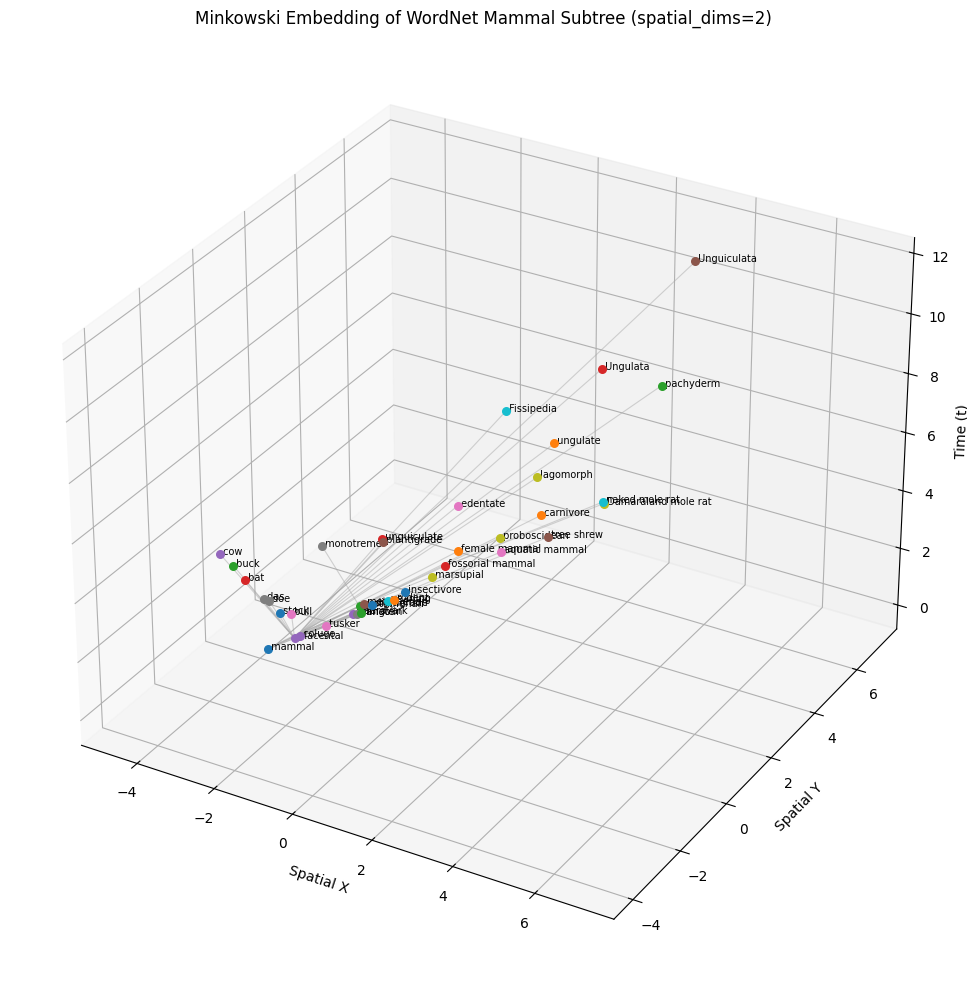

In [ ]:
# @title WordNet Embeddings with BERT!
import nltk
from nltk.corpus import wordnet as wn
import torch
from transformers import BertTokenizer, BertModel
import numpy as np
import matplotlib.pyplot as plt

# --- Ensure NLTK WordNet is available ---
try:
    wn.ensure_loaded()
except LookupError:
    nltk.download("wordnet")
    nltk.download("omw-1.4")  # For broader compatibility
    wn.ensure_loaded()
# === CONFIGURATION ==================================================
BERT_MODEL_NAME = "bert-base-uncased"
NUM_DIMENSIONS = 2
print("Loading BERT model and tokenizer (if not already loaded)...")
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME)
bert_model.eval()
print("BERT loaded.")
# === Helper functions ===============================================


def get_bert_embedding(text, model, tokenizer):
    inputs = tokenizer(
        text, return_tensors="pt", truncation=True, padding=True, max_length=512
    )
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()


# --- WordNet Mammal Subtree Function ---
def get_mammal_concepts(depth_limit=3, start_synset_name="mammal.n.01"):
    concepts = {}
    try:
        mammal_root_synset = wn.synset(start_synset_name)
    except Exception as e:
        print(f"Error accessing WordNet synset '{start_synset_name}': {e}")
        print(
            "Make sure NLTK WordNet data is downloaded and the synset name is correct."
        )
        return {}

    queue = [(mammal_root_synset, 0, None)]
    visited_synsets = set()
    processed_names = (
        set()
    )  # To handle cases where different synsets might yield same primary lemma

    while queue:
        current_synset, depth, parent_name = queue.pop(0)

        if current_synset in visited_synsets or depth > depth_limit:
            continue
        visited_synsets.add(current_synset)

        # Try to get a clean name, prefer single words if possible
        name = None
        lemmas = current_synset.lemmas()
        if lemmas:
            name = lemmas[0].name().replace("_", " ")
            # Prefer shorter names or names without hyphens if multiple lemmas give same concept
            for lem in lemmas[1:]:
                temp_name = lem.name().replace("_", " ")
                if len(temp_name) < len(name) and "-" not in temp_name:
                    name = temp_name

        if (
            name is None or name in processed_names
        ):  # Skip if no good name or name already processed from another synset
            continue
        processed_names.add(name)

        concepts[name] = {
            "synset": current_synset,
            "depth": depth,
            "parents": set(),
            "children": set(),
        }

        if (
            parent_name and parent_name in concepts
        ):  # Ensure parent was successfully added
            concepts[name]["parents"].add(parent_name)
            concepts[parent_name]["children"].add(name)

        for hyponym in current_synset.hyponyms():
            queue.append((hyponym, depth + 1, name))
    return concepts


print("=== Minkowski Embedding Demo with WordNet Mammals and BERT ===")

# === 1. Load Mammal Concepts from WordNet =====================================================
print("\nLoading mammal concepts from WordNet...")
# 'placental.n.01' or 'carnivore.n.01' can give interesting subtrees
mammal_data_wn = get_mammal_concepts(
    depth_limit=NUM_DIMENSIONS, start_synset_name="mammal.n.01"
)

if not mammal_data_wn:
    print("Failed to load WordNet concepts. Exiting demo.")
    # exit() # Use this if running as a script
else:
    print(f"Loaded {len(mammal_data_wn)} mammal-related concepts from WordNet.")
    # print("Sample concepts:", list(mammal_data_wn.keys())[:10])
# ================================================================================================

# 2. === Generate Actual BERT Embeddings =========================================================
concept_bert_embeddings_wn = {}
if mammal_data_wn:
    print("\nGenerating BERT embeddings for WordNet concepts...")
    for name in mammal_data_wn.keys():
        try:
            concept_bert_embeddings_wn[name] = get_bert_embedding(
                name, bert_model, tokenizer
            )
        except Exception as e:
            print(f"Error getting BERT embedding for '{name}': {e}")
    print(f"Generated {len(concept_bert_embeddings_wn)} BERT embeddings.")
    if len(concept_bert_embeddings_wn) < len(mammal_data_wn):
        print("Warning: Not all WordNet concepts received a BERT embedding.")
        # Filter mammal_data_wn to only include concepts for which we have embeddings
        mammal_data_wn = {
            name: data
            for name, data in mammal_data_wn.items()
            if name in concept_bert_embeddings_wn
        }
        print(f"Proceeding with {len(mammal_data_wn)} concepts that have embeddings.")


# 3. === Define Hierarchy from WordNet Data ========================================================
hierarchy_wn = []
root_wn_name = None
min_depth_wn = float("inf")

if mammal_data_wn:
    for name, data in mammal_data_wn.items():
        if not data["parents"]:  # Potential root
            if data["depth"] <= min_depth_wn:  # Find the highest root
                min_depth_wn = data["depth"]
                root_wn_name = name
        for parent_name in data["parents"]:
            if (
                parent_name in mammal_data_wn
            ):  # Ensure parent is also in our selected concept set
                hierarchy_wn.append((name, parent_name))

    if root_wn_name:
        hierarchy_wn.append((root_wn_name, None))
        print(f"Identified WordNet hierarchy root: {root_wn_name}")
    elif mammal_data_wn:  # Fallback if no explicit root was easily found (e.g. if start_synset had parents outside depth_limit)
        # Find any node with no parents WITHIN the current mammal_data_wn set
        all_children_in_set = {child for child, parent in hierarchy_wn}
        potential_roots = [
            name for name in mammal_data_wn.keys() if name not in all_children_in_set
        ]
        if potential_roots:
            root_wn_name = min(
                potential_roots, key=lambda r: mammal_data_wn[r]["depth"]
            )  # Pick highest one
            hierarchy_wn.append((root_wn_name, None))
            print(f"Fallback WordNet hierarchy root: {root_wn_name}")
        else:
            print(
                "Warning: Could not definitively identify a single root for the WordNet hierarchy subset."
            )

    # Ensure hierarchy_wn contains only concepts present in concept_bert_embeddings_wn
    valid_concepts_for_hierarchy = set(concept_bert_embeddings_wn.keys())
    hierarchy_wn_filtered = []
    for child, parent in hierarchy_wn:
        if child in valid_concepts_for_hierarchy and (
            parent is None or parent in valid_concepts_for_hierarchy
        ):
            hierarchy_wn_filtered.append((child, parent))
    hierarchy_wn = sorted(
        list(set(hierarchy_wn_filtered))
    )  # Remove duplicates and sort

    print(f"Constructed hierarchy with {len(hierarchy_wn)} pairs for embedding.")


# === 4. Set Parameters ====================================================================================================
spatial_dimensions_wn = 2  # (t, x, y)
epsilon_wn = 1e-5  # make this smaller for more challenging strict inequality.

# 5. === Run the LLM's embedding function ==================================================================================
if concept_bert_embeddings_wn and hierarchy_wn:
    print("\nComputing Minkowski Embedding for WordNet data...")
    minkowski_coordinates_wn = compute_minkowski_embedding(
        concept_bert_embeddings_wn, hierarchy_wn, spatial_dimensions_wn, epsilon_wn
    )

    print("\n--- Computed Minkowski Coordinates for WordNet concepts (sample) ---")
    if minkowski_coordinates_wn:
        for i, (name, coords) in enumerate(minkowski_coordinates_wn.items()):
            if i < 10:  # Print first 10
                print(
                    f"{name}: [{coords[0]:.3f}, "
                    + ", ".join([f"{c:.3f}" for c in coords[1:]])
                    + "]"
                )
            elif i == 10:
                print("...")
    else:
        print("No WordNet coordinates were computed.")

    # 6. === Basic Causal Consistency Check ==============================================================================
    print("\n--- Causal Consistency Check for WordNet Hierarchy ---")
    all_constraints_met_wn = True
    violations_count = 0
    checked_constraints = 0
    if minkowski_coordinates_wn:
        for child_name, parent_name in hierarchy_wn:
            if parent_name is None:
                continue
            checked_constraints += 1
            if (
                child_name in minkowski_coordinates_wn
                and parent_name in minkowski_coordinates_wn
            ):
                child_c = minkowski_coordinates_wn[child_name]
                parent_c = minkowski_coordinates_wn[parent_name]
                is_consistent = check_causal_link_eval(
                    child_c, parent_c, epsilon_wn, spatial_dimensions_wn
                )
                if not is_consistent:
                    print(f"VIOLATION: {parent_name} -> {child_name}")
                    all_constraints_met_wn = False
                    violations_count += 1
            else:
                print(
                    f"Warning: {child_name} or {parent_name} not in output for WordNet check."
                )
                all_constraints_met_wn = False
                violations_count += 1

        if violations_count > 0:
            print(
                f"{violations_count}/{checked_constraints} causal constraints VIOLATED for WordNet hierarchy."
            )
        elif checked_constraints > 0:
            print(
                f"All {checked_constraints} checked causal constraints met for WordNet hierarchy!"
            )
        else:
            print(
                "No constraints to check for WordNet hierarchy (hierarchy empty or nodes missing)."
            )

    # 7. === Visualization =========================================================================================================
    if (
        minkowski_coordinates_wn
        and (spatial_dimensions_wn == 2 or spatial_dimensions_wn == 1)
        and len(minkowski_coordinates_wn) > 1
    ):
        print("\nVisualizing WordNet Minkowski Embedding...")
        fig_wn = plt.figure(figsize=(12, 10))

        # Determine plot type based on spatial_dims
        if spatial_dimensions_wn == 2:
            ax_wn = fig_wn.add_subplot(111, projection="3d")
            ax_wn.set_xlabel("Spatial X")
            ax_wn.set_ylabel("Spatial Y")
            ax_wn.set_zlabel("Time (t)")
            coords_to_plot = [
                (coords[1], coords[2], coords[0])
                for coords in minkowski_coordinates_wn.values()
            ]  # x,y,t
            link_coords_indices = (1, 2, 0)
        elif spatial_dimensions_wn == 1:
            ax_wn = fig_wn.add_subplot(111)
            ax_wn.set_xlabel("Spatial X")
            ax_wn.set_ylabel("Time (t)")
            coords_to_plot = [
                (coords[1], coords[0]) for coords in minkowski_coordinates_wn.values()
            ]  # x,t
            link_coords_indices = (1, 0)
        else:  # Should not happen with current spatial_dimensions_wn setting
            print("Unsupported spatial dimensions for this plotting snippet.")
            coords_to_plot = []

        if coords_to_plot:
            # Scatter plot points
            unique_names = list(minkowski_coordinates_wn.keys())
            for i, name in enumerate(unique_names):
                coords = minkowski_coordinates_wn[name]
                if spatial_dimensions_wn == 2:
                    ax_wn.scatter(
                        coords[link_coords_indices[0]],
                        coords[link_coords_indices[1]],
                        coords[link_coords_indices[2]],
                        s=30,
                    )
                    ax_wn.text(
                        coords[link_coords_indices[0]],
                        coords[link_coords_indices[1]],
                        coords[link_coords_indices[2]],
                        f" {name}",
                        fontsize=7,
                    )
                elif spatial_dimensions_wn == 1:
                    ax_wn.scatter(
                        coords[link_coords_indices[0]],
                        coords[link_coords_indices[1]],
                        s=30,
                    )
                    ax_wn.text(
                        coords[link_coords_indices[0]],
                        coords[link_coords_indices[1]],
                        f" {name}",
                        fontsize=7,
                    )

            # Plot hierarchy links
            for child_name, parent_name in hierarchy_wn:
                if (
                    parent_name is None
                    or child_name not in minkowski_coordinates_wn
                    or parent_name not in minkowski_coordinates_wn
                ):
                    continue
                p1_coords = minkowski_coordinates_wn[parent_name]
                p2_coords = minkowski_coordinates_wn[child_name]

                plot_args = []
                for idx in link_coords_indices:  # x, y, t or x, t
                    plot_args.extend([[p1_coords[idx], p2_coords[idx]]])
                ax_wn.plot(*plot_args, c="darkgrey", alpha=0.5, linewidth=0.8)

            plt.title(
                f"Minkowski Embedding of WordNet Mammal Subtree (spatial_dims={spatial_dimensions_wn})"
            )
            plt.tight_layout()
            plt.show()

elif not mammal_data_wn:
    print("Demo cannot run as WordNet data was not loaded.")
elif not concept_bert_embeddings_wn:
    print("Demo cannot run as BERT embeddings were not generated for WordNet concepts.")
elif not hierarchy_wn:
    print("Demo cannot run as no hierarchy pairs were constructed for WordNet data.")


=== Euclidean Path Integral Analogy Demo ===
Root for path analysis: mammal
Identified 34 leaf nodes (e.g., ['female mammal', 'Damaraland mole rat', 'primate']...).
Found 34 paths from root to various leaves.

Top 5 Paths with Minimum 'Euclidean Action' Proxy:
  Action: 1.2763 - Path: mammal -> placental -> colugo
  Action: 1.4099 - Path: mammal -> placental -> bull
  Action: 1.4782 - Path: mammal -> placental -> stock
  Action: 1.7629 - Path: mammal -> placental -> doe
  Action: 1.8442 - Path: mammal -> placental -> das

Visualizing Semantic Paths in (Spatial, Tau) Space...


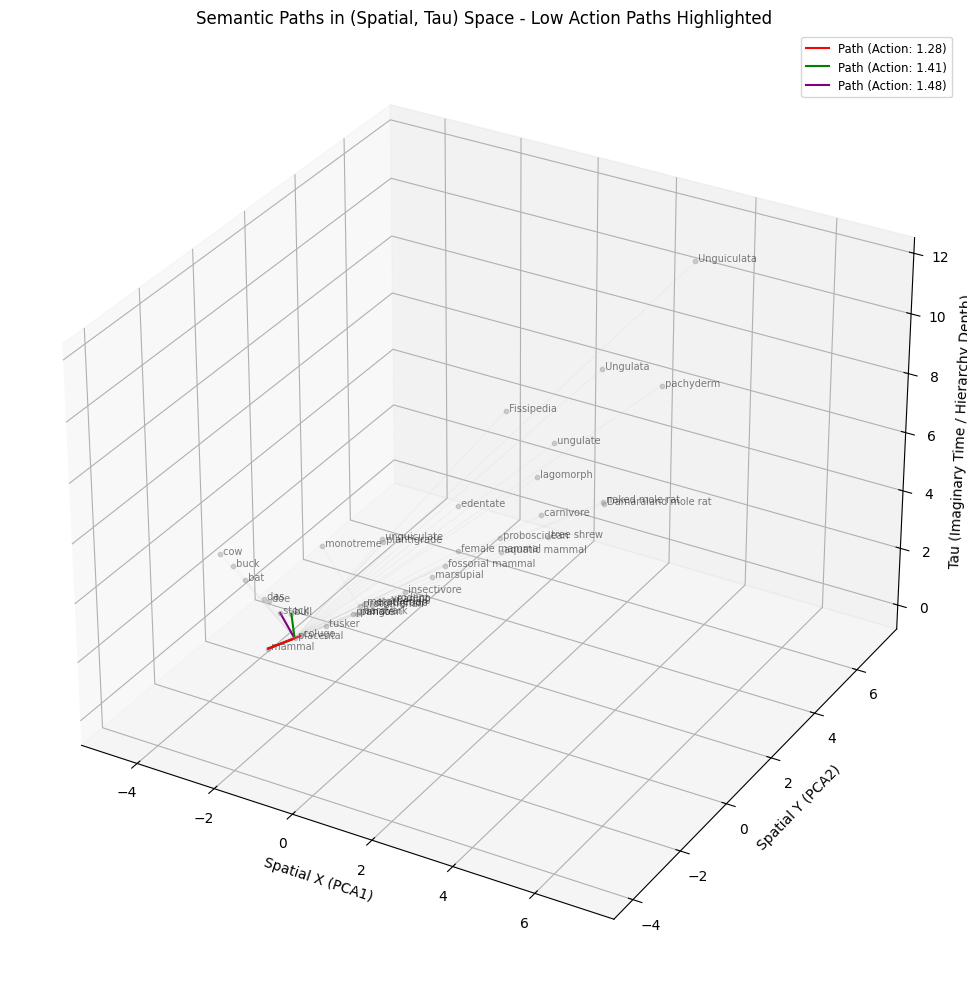

In [ ]:
# @title Defining Ecludiean Action by the distance between points.
import numpy as np
import matplotlib.pyplot as plt

print("\n=== Euclidean Path Integral Analogy Demo ===")
if not minkowski_coordinates_wn or not hierarchy_wn or not root_wn_name:
    print(
        "Required data (minkowski_coordinates_wn, hierarchy_wn, root_wn_name) not found. Skipping this demo."
    )
    # exit() # or skip this block in Colab
    pass
else:
    # --- 1. Re-interpret t as τ and prepare data ----------------------------------------------------------------
    # Our coordinates are already [t, x, y, ...] so t is coords[0]
    # We will call it tau for clarity in this context.
    # Build an adjacency list for easier path traversal (children of a parent)
    parent_to_children_map = defaultdict(list)
    # And child to parent for finding leaves quickly (or just check who is not a parent)
    is_parent_map = defaultdict(bool)

    for child, parent in hierarchy_wn:
        if parent is not None:
            parent_to_children_map[parent].append(child)
            is_parent_map[parent] = True
        # else: child is a root
    all_nodes_in_paths = set(minkowski_coordinates_wn.keys())
    leaf_nodes = [
        node for node in all_nodes_in_paths if not parent_to_children_map[node]
    ]
    print(f"Root for path analysis: {root_wn_name}")
    print(f"Identified {len(leaf_nodes)} leaf nodes (e.g., {leaf_nodes[:3]}...).")

    # --- 2. Function to find all paths from root to a leaf -----------------------------------------------
    def find_all_paths(graph_adj, start_node, end_node, path=None):
        if path is None:
            path = []
        path = path + [start_node]
        if start_node == end_node:
            return [path]
        if start_node not in graph_adj:
            return []
        paths = []
        for neighbor in graph_adj[start_node]:
            if neighbor not in path:  # Avoid cycles (should not happen in DAG)
                new_paths = find_all_paths(graph_adj, neighbor, end_node, path)
                for new_path in new_paths:
                    paths.append(new_path)
        return paths

    all_root_to_leaf_paths = []
    for leaf in leaf_nodes:
        if (
            root_wn_name in minkowski_coordinates_wn
            and leaf in minkowski_coordinates_wn
        ):
            # Need to reverse hierarchy for path finding from root (parent -> children)
            paths_to_leaf = find_all_paths(parent_to_children_map, root_wn_name, leaf)
            all_root_to_leaf_paths.extend(paths_to_leaf)

    print(f"Found {len(all_root_to_leaf_paths)} paths from root to various leaves.")

    # --- 3. Define and Calculate "Euclidean Action" Analogue for each path ---------------------------
    path_actions = []

    def calculate_euclidean_action_proxy(path_nodes, coordinates):
        action = 0.0
        if len(path_nodes) < 2:
            return 0.0  # Or some default for single-node paths

        for i in range(len(path_nodes) - 1):
            node1_name = path_nodes[i]
            node2_name = path_nodes[i + 1]

            if node1_name not in coordinates or node2_name not in coordinates:
                # print(f"Warning: Node missing in coordinates for action calc: {node1_name} or {node2_name}")
                return float("inf")  # Penalize paths with missing nodes

            coord1 = np.array(coordinates[node1_name])
            coord2 = np.array(coordinates[node2_name])

            tau1, spatial1 = coord1[0], coord1[1:]
            tau2, spatial2 = coord2[0], coord2[1:]

            delta_tau = tau2 - tau1
            delta_spatial_sq = np.sum((spatial2 - spatial1) ** 2)

            if delta_tau <= 1e-7:  # Avoid division by zero or very small tau step
                # If tau doesn't change but spatial does, it's "infinite action" in this simple model
                action += float("inf") if delta_spatial_sq > 1e-7 else 0
            else:
                # Simplified action: sum of (spatial_change_sq / time_change)
                # This penalizes large spatial jumps over small "tau" intervals
                action += delta_spatial_sq / delta_tau
        return action

    for path in all_root_to_leaf_paths:
        action = calculate_euclidean_action_proxy(path, minkowski_coordinates_wn)
        if action != float("inf"):
            path_actions.append({"path": path, "action": action})
            # print(f"Path: {' -> '.join(path)}, Action: {action:.4f}")

    # Sort paths by action (lower is "more probable" / "less effort")
    if path_actions:
        path_actions.sort(key=lambda x: x["action"])
        print("\nTop 5 Paths with Minimum 'Euclidean Action' Proxy:")
        for item in path_actions[:5]:
            print(f"  Action: {item['action']:.4f} - Path: {' -> '.join(item['path'])}")
    else:
        print("No valid paths found to calculate actions for.")

    # --- 4. Visualization of Paths in (x, y, τ) Space ----------------------------------------------------------------------------
    # We will plot all found paths, and highlight a few "low action" paths.

    if (
        minkowski_coordinates_wn
        and (spatial_dimensions_wn == 2 or spatial_dimensions_wn == 1)
        and len(all_root_to_leaf_paths) > 0
    ):
        print("\nVisualizing Semantic Paths in (Spatial, Tau) Space...")
        fig_paths = plt.figure(figsize=(12, 10))

        if spatial_dimensions_wn == 2:
            ax_paths = fig_paths.add_subplot(111, projection="3d")
            ax_paths.set_xlabel("Spatial X (PCA1)")
            ax_paths.set_ylabel("Spatial Y (PCA2)")
            ax_paths.set_zlabel("Tau (Imaginary Time / Hierarchy Depth)")
            coord_indices = (1, 2, 0)  # x, y, tau(t)
        elif spatial_dimensions_wn == 1:
            ax_paths = fig_paths.add_subplot(111)
            ax_paths.set_xlabel("Spatial X (PCA1)")
            ax_paths.set_ylabel("Tau (Imaginary Time / Hierarchy Depth)")
            coord_indices = (1, 0)  # x, tau(t)
        else:
            print("Cannot visualize paths for current spatial_dimensions_wn.")
            # exit()

        # Plot all nodes once for context
        all_path_plot_nodes = set(n for p in all_root_to_leaf_paths for n in p)
        for node_name in all_path_plot_nodes:
            if node_name in minkowski_coordinates_wn:
                coords = minkowski_coordinates_wn[node_name]
                if spatial_dimensions_wn == 2:
                    ax_paths.scatter(
                        coords[coord_indices[0]],
                        coords[coord_indices[1]],
                        coords[coord_indices[2]],
                        color="gray",
                        alpha=0.3,
                        s=10,
                    )
                    if len(all_path_plot_nodes) < 40:  # Label if not too cluttered
                        ax_paths.text(
                            coords[coord_indices[0]],
                            coords[coord_indices[1]],
                            coords[coord_indices[2]],
                            f" {node_name}",
                            fontsize=7,
                            alpha=0.5,
                        )
                elif spatial_dimensions_wn == 1:
                    ax_paths.scatter(
                        coords[coord_indices[0]],
                        coords[coord_indices[1]],
                        color="gray",
                        alpha=0.3,
                        s=10,
                    )
                    if len(all_path_plot_nodes) < 40:
                        ax_paths.text(
                            coords[coord_indices[0]],
                            coords[coord_indices[1]],
                            f" {node_name}",
                            fontsize=7,
                            alpha=0.5,
                        )

        # Plot paths: all paths in light color, low action paths highlighted
        num_paths_to_highlight = min(3, len(path_actions))
        highlight_colors = ["red", "green", "purple"]

        for i, item in enumerate(path_actions):
            path_nodes = item["path"]
            path_coords_list = []
            valid_path = True
            for node_name in path_nodes:
                if node_name in minkowski_coordinates_wn:
                    path_coords_list.append(minkowski_coordinates_wn[node_name])
                else:
                    valid_path = False
                    break

            if not valid_path or len(path_coords_list) < 2:
                continue

            path_coords_np = np.array(path_coords_list)

            line_color = (
                highlight_colors[i % num_paths_to_highlight]
                if i < num_paths_to_highlight
                else "lightgray"
            )
            line_alpha = 1.0 if i < num_paths_to_highlight else 0.3
            line_width = 1.5 if i < num_paths_to_highlight else 0.5
            z_order = 10 - i if i < num_paths_to_highlight else 1

            plot_args_path = []
            for idx_dim in range(len(coord_indices)):  # For x,y,t or x,t
                actual_coord_idx = coord_indices[idx_dim]
                plot_args_path.append(path_coords_np[:, actual_coord_idx])

            if spatial_dimensions_wn == 2:
                ax_paths.plot(
                    *plot_args_path,
                    color=line_color,
                    alpha=line_alpha,
                    linewidth=line_width,
                    zorder=z_order,
                    label=f"Path (Action: {item['action']:.2f})"
                    if i < num_paths_to_highlight
                    else None,
                )
            elif spatial_dimensions_wn == 1:
                ax_paths.plot(
                    *plot_args_path,
                    color=line_color,
                    alpha=line_alpha,
                    linewidth=line_width,
                    zorder=z_order,
                    label=f"Path (Action: {item['action']:.2f})"
                    if i < num_paths_to_highlight
                    else None,
                )

        if num_paths_to_highlight > 0 and any(
            pa["action"] != float("inf") for pa in path_actions
        ):
            ax_paths.legend(fontsize="small")
        plt.title(
            "Semantic Paths in (Spatial, Tau) Space - Low Action Paths Highlighted"
        )
        plt.tight_layout()
        plt.show()

    else:
        print(
            "Cannot visualize: Missing coordinates, spatial dimensions not 1 or 2, or no paths found."
        )


=== Euclidean Path Integral Analogy with Semantic Potential Demo ===

Top 5 Paths with 'Euclidean Action + Semantic Potential' (W_sim=0.5):
  Action: 1.3413 - Path: mammal -> placental -> colugo
    Details for first segment of top path (mammal -> placental):
      from: mammal
      to: placental
      d_tau: 0.946
      d_sp_sq: 0.894
      bert_sim: 0.9277571439743042
      kinetic_action: 0.946
      potential_action: 0.0361214280128479
      total_seg_action: 0.982
  Action: 1.4829 - Path: mammal -> placental -> bull
  Action: 1.5451 - Path: mammal -> placental -> stock
  Action: 1.8357 - Path: mammal -> placental -> doe
  Action: 1.9115 - Path: mammal -> placental -> das

Searching for 'Instanton-like' Segments in Low-Action Paths...
No clear instanton-like segments found with threshold 0.5 in top 20 paths.

Visualizing Semantic Paths (with Semantic Potential in Action)...


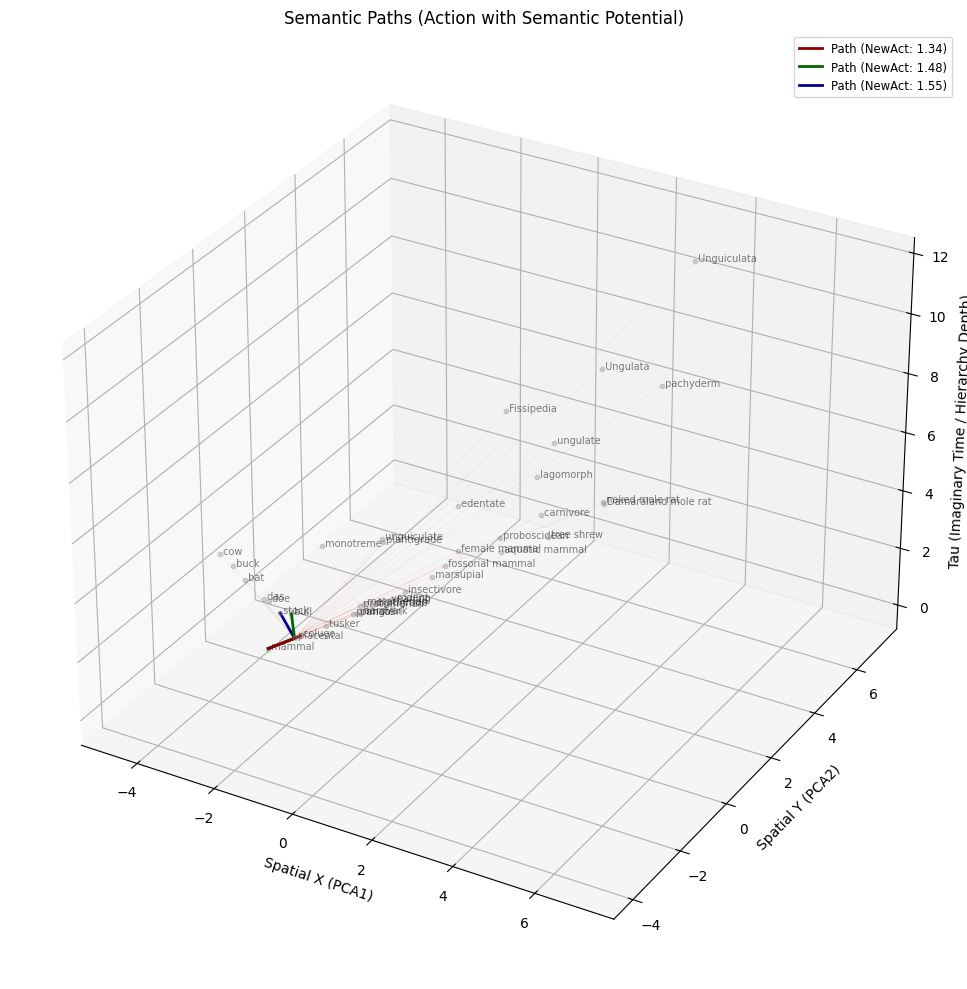

In [ ]:
# @title Ecludean Path Integral with Semantic Potential
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity  # For BERT similarity

print("\n=== Euclidean Path Integral Analogy with Semantic Potential Demo ===")

if (
    not minkowski_coordinates_wn
    or not hierarchy_wn
    or not root_wn_name
    or not concept_bert_embeddings_wn
    or "parent_to_children_map" not in globals()
    or "all_root_to_leaf_paths" not in globals()
):
    print("Required data not found from previous steps. Skipping this demo.")
    # exit()
    pass
else:
    # --- 1. Define a new "Euclidean Action" incorporating BERT similarity ---
    # This action penalizes both spatial "jerkiness" and traversing
    # links between concepts that BERT considers dissimilar.
    # Weight for the similarity penalty in the action
    # If the same meanings hold for higher values then it means the semantics are robust.
    W_SIMILARITY_PENALTY = 0.5  # Tune this: higher means more penalty for low BERT sim

    path_actions_v2 = []

    def calculate_euclidean_action_with_potential(
        path_nodes, coordinates, bert_embeddings
    ):
        action = 0.0
        if len(path_nodes) < 2:
            return 0.0

        path_segment_details = []

        for i in range(len(path_nodes) - 1):
            node1_name = path_nodes[i]
            node2_name = path_nodes[i + 1]

            if (
                node1_name not in coordinates
                or node2_name not in coordinates
                or node1_name not in bert_embeddings
                or node2_name not in bert_embeddings
            ):
                return float("inf"), []  # Path is invalid if nodes are missing

            coord1 = np.array(coordinates[node1_name])
            coord2 = np.array(coordinates[node2_name])
            bert1 = np.array(bert_embeddings[node1_name]).reshape(1, -1)
            bert2 = np.array(bert_embeddings[node2_name]).reshape(1, -1)

            tau1, spatial1 = coord1[0], coord1[1:]
            tau2, spatial2 = coord2[0], coord2[1:]

            delta_tau = tau2 - tau1
            delta_spatial_sq = np.sum((spatial2 - spatial1) ** 2)

            bert_sim = cosine_similarity(bert1, bert2)[0, 0]
            # Ensure similarity is between -1 and 1 for (1-sim) to be non-negative
            bert_sim = np.clip(bert_sim, -1.0, 1.0)
            similarity_cost = 1.0 - bert_sim  # Higher for dissimilar concepts (max 2)

            segment_action_kinetic = 0
            if delta_tau <= 1e-7:
                segment_action_kinetic = float("inf") if delta_spatial_sq > 1e-7 else 0
            else:
                segment_action_kinetic = delta_spatial_sq / delta_tau

            segment_action_potential = W_SIMILARITY_PENALTY * similarity_cost
            total_segment_action = segment_action_kinetic + segment_action_potential
            action += total_segment_action

            path_segment_details.append(
                {
                    "from": node1_name,
                    "to": node2_name,
                    "d_tau": delta_tau,
                    "d_sp_sq": delta_spatial_sq,
                    "bert_sim": bert_sim,
                    "kinetic_action": segment_action_kinetic,
                    "potential_action": segment_action_potential,
                    "total_seg_action": total_segment_action,
                }
            )

        return action, path_segment_details

    for path in all_root_to_leaf_paths:
        action, details = calculate_euclidean_action_with_potential(
            path, minkowski_coordinates_wn, concept_bert_embeddings_wn
        )
        if action != float("inf"):
            path_actions_v2.append({"path": path, "action": action, "details": details})

    if path_actions_v2:
        path_actions_v2.sort(key=lambda x: x["action"])
        print(
            f"\nTop 5 Paths with 'Euclidean Action + Semantic Potential' (W_sim={W_SIMILARITY_PENALTY}):"
        )
        for item in path_actions_v2[:5]:
            print(f"  Action: {item['action']:.4f} - Path: {' -> '.join(item['path'])}")
            # Print details for the first segment of the top path for illustration
            if item == path_actions_v2[0] and item["details"]:
                print(
                    f"    Details for first segment of top path ({item['details'][0]['from']} -> {item['details'][0]['to']}):"
                )
                for key, val in item["details"][0].items():
                    if isinstance(val, float):
                        print(f"      {key}: {val:.3f}")
                    else:
                        print(f"      {key}: {val}")
    else:
        print("No valid paths found to calculate V2 actions for.")

    # --- 2. Identifying "Instanton-like" Path Segments ---
    # An instanton-like segment might be one with:
    #   a) Low BERT similarity (high "potential barrier" crossed)
    #   b) But its contribution to total path action isn't excessively high, meaning
    #      either delta_tau was large for that segment, or delta_spatial_sq was small.
    #   c) And the overall path action is still relatively low.
    print("\nSearching for 'Instanton-like' Segments in Low-Action Paths...")
    instanton_candidates = []
    SIMILARITY_BARRIER_THRESHOLD = 0.5  # BERT similarity below this is a "barrier"
    MAX_PATHS_TO_CHECK = 20  # Check more than just top 5

    for item in path_actions_v2[:MAX_PATHS_TO_CHECK]:
        for segment in item["details"]:
            if segment["bert_sim"] < SIMILARITY_BARRIER_THRESHOLD:
                # This segment crossed a "semantic potential barrier"
                # If its individual segment action is not too high, and path action is low, it's a candidate
                # This definition is heuristic.
                if (
                    segment["total_seg_action"]
                    < (
                        item["action"] / (len(item["path"]) - 1)
                        if len(item["path"]) > 1
                        else float("inf")
                    )
                    * 2.0
                ):  # Segment action not disproportionately high
                    instanton_candidates.append(
                        {
                            "path": " -> ".join(item["path"]),
                            "path_action": item["action"],
                            "segment": f"{segment['from']} -> {segment['to']}",
                            "segment_bert_sim": segment["bert_sim"],
                            "segment_action": segment["total_seg_action"],
                            "segment_d_tau": segment["d_tau"],
                            "segment_d_sp_sq": segment["d_sp_sq"],
                        }
                    )

    if instanton_candidates:
        instanton_candidates.sort(
            key=lambda x: (x["path_action"], x["segment_bert_sim"])
        )  # Low path action, very low sim
        print(
            f"Found {len(instanton_candidates)} potential instanton-like segments crossing similarity < {SIMILARITY_BARRIER_THRESHOLD}."
        )
        print(
            "Top 3 Candidates (Low Path Action, Low Segment BERT Sim but reasonable segment action):"
        )
        for cand in instanton_candidates[:3]:
            print(f"  Path (Action {cand['path_action']:.2f}): {cand['path']}")
            print(
                f"    Segment: {cand['segment']} (Sim: {cand['segment_bert_sim']:.2f}, SegAct: {cand['segment_action']:.2f}, dτ: {cand['segment_d_tau']:.2f}, dX²: {cand['segment_d_sp_sq']:.2f})"
            )
    else:
        print(
            f"No clear instanton-like segments found with threshold {SIMILARITY_BARRIER_THRESHOLD} in top {MAX_PATHS_TO_CHECK} paths."
        )

    # --- 3. Visualization -----------------------------------------------------------------
    # Code is similar from above, for a script create a function.
    # Highlight paths containing instanton-like segments, or simply the new top paths.
    # For this demo, we'll just highlight the new top paths based on action_v2
    if (
        minkowski_coordinates_wn
        and (spatial_dimensions_wn == 2 or spatial_dimensions_wn == 1)
        and len(path_actions_v2) > 0
    ):
        print("\nVisualizing Semantic Paths (with Semantic Potential in Action)...")
        fig_paths_v2 = plt.figure(figsize=(12, 10))

        if spatial_dimensions_wn == 2:
            ax_paths_v2 = fig_paths_v2.add_subplot(111, projection="3d")
            ax_paths_v2.set_xlabel("Spatial X (PCA1)")
            ax_paths_v2.set_ylabel("Spatial Y (PCA2)")
            ax_paths_v2.set_zlabel("Tau (Imaginary Time / Hierarchy Depth)")
            coord_indices = (1, 2, 0)  # x, y, tau(t)
        elif spatial_dimensions_wn == 1:
            ax_paths_v2 = fig_paths_v2.add_subplot(111)
            ax_paths_v2.set_xlabel("Spatial X (PCA1)")
            ax_paths_v2.set_ylabel("Tau (Imaginary Time / Hierarchy Depth)")
            coord_indices = (1, 0)  # x, tau(t)
        else:
            print("Cannot visualize paths for current spatial_dimensions_wn.")
            # exit()

        all_plot_nodes_v2 = set(n for item in path_actions_v2 for n in item["path"])
        for node_name in all_plot_nodes_v2:
            if node_name in minkowski_coordinates_wn:
                coords = minkowski_coordinates_wn[node_name]
                # Plotting logic as before...
                if spatial_dimensions_wn == 2:
                    ax_paths_v2.scatter(
                        coords[coord_indices[0]],
                        coords[coord_indices[1]],
                        coords[coord_indices[2]],
                        color="gray",
                        alpha=0.3,
                        s=10,
                    )
                    if len(all_plot_nodes_v2) < 40:
                        ax_paths_v2.text(
                            coords[coord_indices[0]],
                            coords[coord_indices[1]],
                            coords[coord_indices[2]],
                            f" {node_name}",
                            fontsize=7,
                            alpha=0.5,
                        )
                elif spatial_dimensions_wn == 1:
                    ax_paths_v2.scatter(
                        coords[coord_indices[0]],
                        coords[coord_indices[1]],
                        color="gray",
                        alpha=0.3,
                        s=10,
                    )
                    if len(all_plot_nodes_v2) < 40:
                        ax_paths_v2.text(
                            coords[coord_indices[0]],
                            coords[coord_indices[1]],
                            f" {node_name}",
                            fontsize=7,
                            alpha=0.5,
                        )

        num_paths_to_highlight_v2 = min(3, len(path_actions_v2))
        highlight_colors_v2 = ["darkred", "darkgreen", "darkblue"]

        for i, item in enumerate(path_actions_v2):  # Use path_actions_v2
            path_nodes = item["path"]
            path_coords_list = [
                minkowski_coordinates_wn[n]
                for n in path_nodes
                if n in minkowski_coordinates_wn
            ]
            if len(path_coords_list) != len(path_nodes) or len(path_coords_list) < 2:
                continue
            path_coords_np = np.array(path_coords_list)

            line_color = (
                highlight_colors_v2[i % num_paths_to_highlight_v2]
                if i < num_paths_to_highlight_v2
                else "lightcoral"
            )
            line_alpha = 1.0 if i < num_paths_to_highlight_v2 else 0.2
            line_width = (
                2.0 if i < num_paths_to_highlight_v2 else 0.3
            )  # Thicker highlights
            z_order = 10 - i if i < num_paths_to_highlight_v2 else 1

            plot_args_path = []
            for idx_dim in range(len(coord_indices)):
                actual_coord_idx = coord_indices[idx_dim]
                plot_args_path.append(path_coords_np[:, actual_coord_idx])

            if spatial_dimensions_wn == 2:
                ax_paths_v2.plot(
                    *plot_args_path,
                    color=line_color,
                    alpha=line_alpha,
                    linewidth=line_width,
                    zorder=z_order,
                    label=f"Path (NewAct: {item['action']:.2f})"
                    if i < num_paths_to_highlight_v2
                    else None,
                )
            elif spatial_dimensions_wn == 1:
                ax_paths_v2.plot(
                    *plot_args_path,
                    color=line_color,
                    alpha=line_alpha,
                    linewidth=line_width,
                    zorder=z_order,
                    label=f"Path (NewAct: {item['action']:.2f})"
                    if i < num_paths_to_highlight_v2
                    else None,
                )

        if num_paths_to_highlight_v2 > 0 and any(
            pa["action"] != float("inf") for pa in path_actions_v2
        ):
            ax_paths_v2.legend(fontsize="small")
        plt.title("Semantic Paths (Action with Semantic Potential)")
        plt.tight_layout()
        plt.show()

In [ ]:
# @title Helper function to find K nearest concepts
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances  # For option 1 & 3


def find_k_nearest_concepts(
    target_concept_name: str,
    all_coordinates: dict[str, list[float]],
    k: int,
    distance_type: str = "spacetime_euclidean",
):
    """
    Finds the k-nearest concepts to a target concept in the embedded space.

    Args:
        target_concept_name: The name of the concept to find neighbors for.
        all_coordinates: Dictionary of {name: [tau, x, y,...]} coordinates.
        k: The number of nearest neighbors to find.
        distance_type:
            "spacetime_euclidean": Euclidean distance in the full (tau, x, y,...) space.
            "spatial_only_euclidean": Euclidean distance in only the spatial (x, y,...) dimensions.
    Returns:
        A list of tuples (concept_name, distance), sorted by distance.
    """
    if target_concept_name not in all_coordinates:
        print(
            f"Error: Target concept '{target_concept_name}' not found in coordinates."
        )
        return []

    target_coord_full = np.array(all_coordinates[target_concept_name])

    if distance_type == "spatial_only_euclidean":
        if len(target_coord_full) <= 1:  # Only tau, no spatial dimensions
            print(
                "Warning: Cannot compute spatial_only distance with 0 spatial dimensions."
            )
            return []
        target_coord_slice = target_coord_full[1:].reshape(1, -1)  # Spatial part only
    elif distance_type == "spacetime_euclidean":
        target_coord_slice = target_coord_full.reshape(1, -1)  # Full (tau, x, y,...)
    else:
        print(f"Error: Unknown distance_type '{distance_type}'.")
        return []

    neighbors = []
    for name, coord_full_list in all_coordinates.items():
        if name == target_concept_name:
            continue

        coord_full = np.array(coord_full_list)

        if distance_type == "spatial_only_euclidean":
            if len(coord_full) <= 1:
                continue  # Skip if no spatial dimensions for this point
            coord_slice = coord_full[1:].reshape(1, -1)
        else:  # spacetime_euclidean
            coord_slice = coord_full.reshape(1, -1)

        # Ensure dimensions match for distance calculation
        if coord_slice.shape[1] != target_coord_slice.shape[1]:
            # This might happen if some concepts have different coord lengths due to an error
            # print(f"Warning: Dimension mismatch for {name}. Skipping.")
            continue

        dist = euclidean_distances(target_coord_slice, coord_slice)[0, 0]
        neighbors.append((name, dist))

    # Sort by distance and take top k
    neighbors.sort(key=lambda x: x[1])
    return neighbors[:k]



--- K-Nearest Concepts Demo ---

Finding 5-nearest concepts to 'yearling':

Nearest in (Tau, X, Y,...) Euclidean space (hierarchical + semantic similarity):
  - insectivore (Distance: 0.4492)
  - aardvark (Distance: 0.6778)
  - pangolin (Distance: 1.0648)
  - digitigrade (Distance: 1.1546)
  - fossorial mammal (Distance: 1.5160)

Nearest in Spatial (X, Y,...) Euclidean space (pure semantic similarity at any depth):
  - insectivore (Distance: 0.3911)
  - aardvark (Distance: 0.6756)
  - pangolin (Distance: 0.7689)
  - digitigrade (Distance: 0.8566)
  - primate (Distance: 1.2922)

Attempting semantic navigation from 'mammal' to 'bat'.

Starting A* search from 'mammal' to 'bat'...
Goal 'bat' reached! Path cost (g_score): 2.3848
True directional action of path: 2.3848

--- Navigation Result ---
Lowest 'action' path from 'mammal' to 'bat':
  Path: mammal -> placental -> bat
  Associated Action: 2.3848


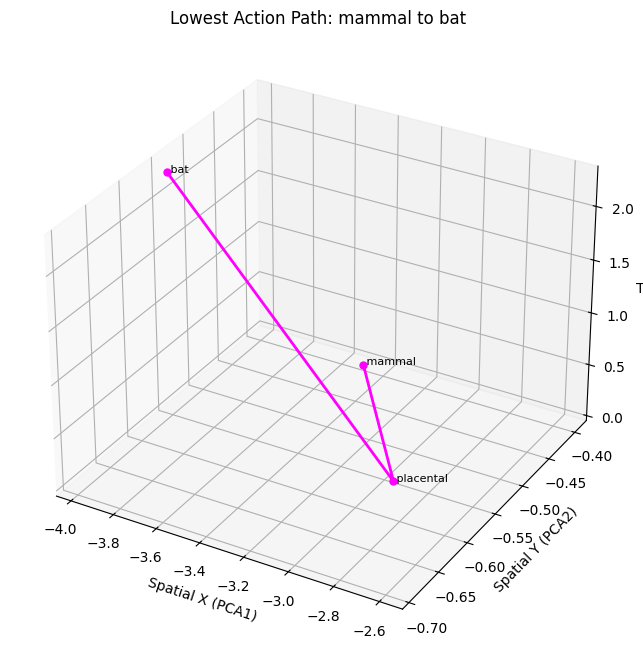

In [ ]:
import heapq  # For priority queue in A*
import numpy as np
import random
from collections import defaultdict

# --- Rebuild child_to_parent_map if necessary for bi-directional search ---
# Or, more generally, an adjacency list for all connections
# For this demo, let's build a general adjacency list (neighbors)
adjacency_list = defaultdict(list)
if "hierarchy_wn" in globals() and hierarchy_wn:  # Check if hierarchy_wn is defined
    processed_edges = set()
    for child, parent in hierarchy_wn:
        if parent is not None:
            # Ensure we don't add duplicate edges if hierarchy_wn has them
            if (parent, child) not in processed_edges:
                adjacency_list[parent].append(child)
                processed_edges.add((parent, child))
            if (
                child,
                parent,
            ) not in processed_edges:  # For A*, allow going "up" the hierarchy too
                adjacency_list[child].append(parent)
                processed_edges.add((child, parent))
else:
    print("Warning: `hierarchy_wn` not found or empty. Navigation will be limited.")
    # Populate adjacency_list from parent_to_children_map if it exists
    if "parent_to_children_map" in globals():
        for parent, children in parent_to_children_map.items():
            for child in children:
                adjacency_list[parent].append(child)
                adjacency_list[child].append(parent)  # Bidirectional for search


# For A*, we need to calculate cost of a single step, not a whole path.
def calculate_step_action(node1_name, node2_name, coordinates, bert_embeddings):
    """Calculates the action for a single step from node1 to node2."""
    if (
        node1_name not in coordinates
        or node2_name not in coordinates
        or node1_name not in bert_embeddings
        or node2_name not in bert_embeddings
    ):
        return float("inf")  # Cannot traverse

    coord1 = np.array(coordinates[node1_name])
    coord2 = np.array(coordinates[node2_name])
    bert1 = np.array(bert_embeddings[node1_name]).reshape(1, -1)
    bert2 = np.array(bert_embeddings[node2_name]).reshape(1, -1)

    tau1, spatial1 = coord1[0], coord1[1:]
    tau2, spatial2 = coord2[0], coord2[1:]

    delta_tau = tau2 - tau1  # This can be negative if going "up" the hierarchy
    delta_spatial_sq = np.sum((spatial2 - spatial1) ** 2)

    bert_sim = cosine_similarity(bert1, bert2)[0, 0]
    bert_sim = np.clip(bert_sim, -1.0, 1.0)
    similarity_cost = 1.0 - bert_sim

    segment_action_kinetic = 0
    # If going "backwards in tau", delta_tau is negative.
    # Action should always be positive.
    # Let's define action for going P->C differently from C->P,
    # or use absolute delta_tau and penalize going against hierarchy flow.
    # For now, let's assume forward hierarchical flow (P->C, so delta_tau > 0).
    # A* will find paths, but their "action" interpretation depends on direction.
    # For simplicity, let's make the "effort" symmetric for A* search,
    # but note that true semantic path action is directional.
    abs_delta_tau = abs(delta_tau)
    if abs_delta_tau <= 1e-7:
        segment_action_kinetic = float("inf") if delta_spatial_sq > 1e-7 else 0
    else:
        # We will use abs_delta_tau for cost calculation for A* to make it symmetric.
        # The "true" action of the final path should be recalculated directionally.
        segment_action_kinetic = delta_spatial_sq / abs_delta_tau
    segment_action_potential = W_SIMILARITY_PENALTY * similarity_cost
    return segment_action_kinetic + segment_action_potential


def a_star_semantic_search(
    start_node, goal_node, adj_list, coordinates, bert_embeddings
):
    if start_node not in coordinates or goal_node not in coordinates:
        print(
            f"Error: Start ({start_node}) or Goal ({goal_node}) node not in coordinates."
        )
        return None, float("inf")

    # Priority queue: (f_score, g_score, current_node, path_list)
    # f_score = g_score + h_score
    # g_score = cost from start to current_node
    open_set = [(0, 0, start_node, [start_node])]
    heapq.heapify(open_set)

    # For heuristic, use spatial Euclidean distance in PCA space to goal
    # This doesn't account for tau, but is a simple start.
    def heuristic(node_name, goal_name):
        if (
            node_name not in coordinates
            or goal_name not in coordinates
            or spatial_dimensions_wn == 0
        ):
            return 0
        coord_node = np.array(coordinates[node_name][1:])  # Spatial part
        coord_goal = np.array(coordinates[goal_name][1:])  # Spatial part
        return np.sqrt(np.sum((coord_node - coord_goal) ** 2))

    # Keep track of visited nodes and g_scores to avoid cycles and redundant exploration
    g_scores = {node: float("inf") for node in adj_list}
    g_scores[start_node] = 0

    print(f"\nStarting A* search from '{start_node}' to '{goal_node}'...")

    path_count = 0
    while open_set:
        path_count += 1
        if path_count > 50000:  # Safety break for large graphs
            print("A* search exceeded max path explorations.")
            return None, float("inf")

        f_score_curr, g_score_curr, current_node, path = heapq.heappop(open_set)

        if current_node == goal_node:
            print(
                f"Goal '{goal_node}' reached! Path cost (g_score): {g_score_curr:.4f}"
            )
            # Recalculate "true" directional action for the found path
            true_action, _ = calculate_euclidean_action_with_potential(
                path, coordinates, bert_embeddings
            )
            print(f"True directional action of path: {true_action:.4f}")
            return path, true_action

        # Explore neighbors
        for neighbor in adj_list.get(current_node, []):
            # Cost to move from current_node to neighbor
            # A* needs a consistent cost for g_score. We use the symmetric step action.
            step_cost = calculate_step_action(
                current_node, neighbor, coordinates, bert_embeddings
            )

            if step_cost == float("inf"):  # Un traversable edge
                continue

            tentative_g_score = g_score_curr + step_cost

            if tentative_g_score < g_scores.get(neighbor, float("inf")):
                g_scores[neighbor] = tentative_g_score
                h_score_neighbor = heuristic(neighbor, goal_node)
                f_score_neighbor = tentative_g_score + h_score_neighbor
                new_path = path + [neighbor]
                heapq.heappush(
                    open_set, (f_score_neighbor, tentative_g_score, neighbor, new_path)
                )

    print(f"Goal '{goal_node}' not reachable from '{start_node}'.")
    return None, float("inf")


# K nearest concepts
if "minkowski_coordinates_wn" in globals() and minkowski_coordinates_wn:
    print("\n\n--- K-Nearest Concepts Demo ---")

    # Concept to find neighbors for (e.g., the goal of our A* search, or any other concept)
    concept_to_query = "dog"  # Example, change as needed
    if (
        "nav_goal_node" in globals()
        and nav_goal_node
        and nav_goal_node in minkowski_coordinates_wn
    ):
        concept_to_query = nav_goal_node  # Use the goal from A* if available
    elif concept_to_query not in minkowski_coordinates_wn and minkowski_coordinates_wn:
        concept_to_query = list(minkowski_coordinates_wn.keys())[
            len(minkowski_coordinates_wn) // 2
        ]  # Pick a middle concept

    num_neighbors = 5

    if concept_to_query in minkowski_coordinates_wn:
        print(f"\nFinding {num_neighbors}-nearest concepts to '{concept_to_query}':")

        # 1. Using Euclidean distance in the full (tau, X, Y,...) space
        nearest_spacetime = find_k_nearest_concepts(
            concept_to_query,
            minkowski_coordinates_wn,
            num_neighbors,
            distance_type="spacetime_euclidean",
        )
        print(
            "\nNearest in (Tau, X, Y,...) Euclidean space (hierarchical + semantic similarity):"
        )
        if nearest_spacetime:
            for name, dist in nearest_spacetime:
                print(f"  - {name} (Distance: {dist:.4f})")
        else:
            print("  No neighbors found or error in calculation.")

        # 2. Using Euclidean distance in only the spatial (X, Y,...) dimensions
        if spatial_dimensions_wn > 0:  # Only if there are spatial dimensions
            nearest_spatial = find_k_nearest_concepts(
                concept_to_query,
                minkowski_coordinates_wn,
                num_neighbors,
                distance_type="spatial_only_euclidean",
            )
            print(
                "\nNearest in Spatial (X, Y,...) Euclidean space (pure semantic similarity at any depth):"
            )
            if nearest_spatial:
                for name, dist in nearest_spatial:
                    print(f"  - {name} (Distance: {dist:.4f})")
            else:
                print(
                    "  No neighbors found or error in calculation (or no spatial dimensions)."
                )
        else:
            print("\nSkipping spatial-only nearest neighbors (0 spatial dimensions).")

    else:
        print(
            f"Cannot find k-nearest concepts: '{concept_to_query}' not in coordinate data."
        )
else:
    print("\nSkipping K-Nearest Concepts Demo: Minkowski coordinates not available.")


# --- Demo Navigation ---
if "minkowski_coordinates_wn" in globals() and minkowski_coordinates_wn:
    # Pick a start and end node for navigation
    # For this demo, let's try to navigate from a high-level concept to a more specific one.
    # Ensure these nodes exist in your current WordNet subset.
    # Find a root and a leaf from the actual data for a meaningful test
    nav_start_node = None
    nav_goal_node = None

    if (
        "root_wn_name" in globals()
        and root_wn_name
        and root_wn_name in minkowski_coordinates_wn
    ):
        nav_start_node = root_wn_name
    elif minkowski_coordinates_wn:  # Pick first available if no explicit root
        nav_start_node = list(minkowski_coordinates_wn.keys())[0]

    # Find a leaf node (a node that is not a parent to any other node in minkowski_coordinates_wn)
    potential_parents_in_coords = set()
    if "hierarchy_wn" in globals() and hierarchy_wn:
        for child, parent in hierarchy_wn:
            if parent is not None and parent in minkowski_coordinates_wn:
                potential_parents_in_coords.add(parent)

    available_leaves = [
        n
        for n in minkowski_coordinates_wn.keys()
        if n not in potential_parents_in_coords
    ]
    if available_leaves:
        nav_goal_node = random.choice(available_leaves)
        # Ensure start and goal are not the same if possible
        if nav_start_node == nav_goal_node and len(available_leaves) > 1:
            temp_leaves = [l for l in available_leaves if l != nav_start_node]
            if temp_leaves:
                nav_goal_node = random.choice(temp_leaves)

    if nav_start_node and nav_goal_node and nav_start_node != nav_goal_node:
        print(
            f"\nAttempting semantic navigation from '{nav_start_node}' to '{nav_goal_node}'."
        )

        optimal_path, optimal_action = a_star_semantic_search(
            nav_start_node,
            nav_goal_node,
            adjacency_list,
            minkowski_coordinates_wn,
            concept_bert_embeddings_wn,
        )

        if optimal_path:
            print("\n--- Navigation Result ---")
            print(f"Lowest 'action' path from '{nav_start_node}' to '{nav_goal_node}':")
            print(f"  Path: {' -> '.join(optimal_path)}")
            print(f"  Associated Action: {optimal_action:.4f}")

            # Visualize this specific path (optional, can be complex if too many nodes)
            if (spatial_dimensions_wn == 2 or spatial_dimensions_wn == 1) and len(
                optimal_path
            ) > 1:
                fig_nav = plt.figure(figsize=(10, 8))
                path_coords_list_nav = [
                    minkowski_coordinates_wn[n]
                    for n in optimal_path
                    if n in minkowski_coordinates_wn
                ]
                if len(path_coords_list_nav) == len(optimal_path):  # All nodes found
                    path_coords_np_nav = np.array(path_coords_list_nav)

                    if spatial_dimensions_wn == 2:
                        ax_nav = fig_nav.add_subplot(111, projection="3d")
                        ax_nav.set_xlabel("Spatial X (PCA1)")
                        ax_nav.set_ylabel("Spatial Y (PCA2)")
                        ax_nav.set_zlabel("Tau")
                        coord_indices_nav = (1, 2, 0)
                        ax_nav.plot(
                            path_coords_np_nav[:, coord_indices_nav[0]],
                            path_coords_np_nav[:, coord_indices_nav[1]],
                            path_coords_np_nav[:, coord_indices_nav[2]],
                            marker="o",
                            linestyle="-",
                            color="magenta",
                            linewidth=2,
                            markersize=5,
                        )
                        for i, node_name in enumerate(optimal_path):
                            ax_nav.text(
                                path_coords_np_nav[i, coord_indices_nav[0]],
                                path_coords_np_nav[i, coord_indices_nav[1]],
                                path_coords_np_nav[i, coord_indices_nav[2]],
                                f" {node_name}",
                                fontsize=8,
                                color="black",
                            )
                    elif spatial_dimensions_wn == 1:
                        ax_nav = fig_nav.add_subplot(111)
                        ax_nav.set_xlabel("Spatial X (PCA1)")
                        ax_nav.set_ylabel("Tau")
                        coord_indices_nav = (1, 0)
                        ax_nav.plot(
                            path_coords_np_nav[:, coord_indices_nav[0]],
                            path_coords_np_nav[:, coord_indices_nav[1]],
                            marker="o",
                            linestyle="-",
                            color="magenta",
                            linewidth=2,
                            markersize=5,
                        )
                        for i, node_name in enumerate(optimal_path):
                            ax_nav.text(
                                path_coords_np_nav[i, coord_indices_nav[0]],
                                path_coords_np_nav[i, coord_indices_nav[1]],
                                f" {node_name}",
                                fontsize=8,
                                color="black",
                            )

                    plt.title(
                        f"Lowest Action Path: {nav_start_node} to {nav_goal_node}"
                    )
                    plt.show()
        else:
            print(f"No path found between '{nav_start_node}' and '{nav_goal_node}'.")
    else:
        print(
            "\nCould not set up a valid start and goal node for navigation demo from the current data."
        )

else:
    print("Minkowski coordinates not available. Skipping navigation demo.")


=== Demo: LLM Inferring Hierarchy and Embedding ===

Generating BERT embeddings for target concepts...
Generated 15 BERT embeddings.

Inferring hierarchy based on BERT similarity and heuristics...
Inferred hierarchy with 15 pairs (this is a heuristic!):
  animal -> None
  canid -> None
  carnivore -> ungulate
  cow -> None
  dog -> None
  feline -> None
  horse -> dog
  human -> None
  meat -> None
  monkey -> cow

Computing Minkowski Embedding for INFERRED hierarchy...

--- Computed Minkowski Coordinates for INFERRED hierarchy (sample) ---
animal: [0.000, 1.586, 2.863]
meat: [0.000, -2.344, -1.417]
placental: [0.489, -1.039, -0.298]
carnivore: [7.806, 5.285, -1.744]
canid: [0.000, -0.678, 0.032]
...

--- Causal Consistency Check for INFERRED Hierarchy ---
All 7 checked causal constraints met for INFERRED hierarchy!

Visualizing INFERRED Hierarchy Minkowski Embedding...


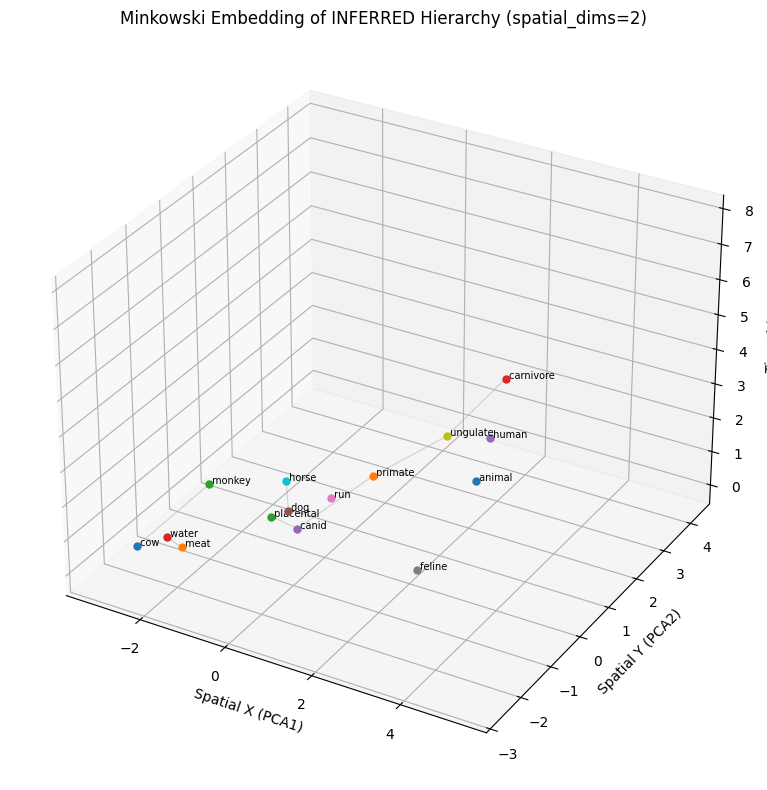

In [ ]:
import nltk
from nltk.corpus import wordnet as wn
import torch
from transformers import BertTokenizer, BertModel
import numpy as np
from collections import defaultdict
import random
import matplotlib.pyplot as plt

# @title --- Main Demo: LLM "Learning" Hierarchy and Embedding -----------------------------
print("\n=== Demo: LLM Inferring Hierarchy and Embedding ===")

# 1. Get Concepts and BERT Embeddings (e.g., from a WordNet subtree)
# For this demo, let's pick a smaller, more focused set of concepts
target_concepts = [
    "animal",
    "meat",
    "placental",
    "carnivore",
    "canid",
    "dog",
    "run",
    "feline",
    "ungulate",
    "horse",
    "cow",
    "primate",
    "monkey",
    "water",
    "human",
]  # Mixed bag

print("\nGenerating BERT embeddings for target concepts...")
concept_bert_embeddings_learned_h = {}
valid_concept_names = []
for name in target_concepts:
    try:
        embedding = get_bert_embedding(name, bert_model, tokenizer)
        if embedding is not None:
            concept_bert_embeddings_learned_h[name] = embedding.tolist()
            valid_concept_names.append(name)
        else:
            print(f"Warning: Could not get embedding for '{name}'.")
    except Exception as e:
        print(f"Error getting BERT embedding for '{name}': {e}")

if not concept_bert_embeddings_learned_h:
    print("No BERT embeddings generated. Cannot proceed.")
    # exit()
else:
    print(f"Generated {len(concept_bert_embeddings_learned_h)} BERT embeddings.")


# 2. Infer Hierarchy (Simplified "Learning" based on BERT Similarity + Heuristics)
# This is a HEURISTIC proxy for an LLM learning "possible tasks/links"
# A more advanced LLM would use its internal knowledge or be trained for this.
print("\nInferring hierarchy based on BERT similarity and heuristics...")
inferred_hierarchy_pairs = []
similarity_threshold = 0.80  # Consider concepts highly similar if cos_sim > threshold
potential_parents_map = defaultdict(list)

# Create a matrix of embeddings for faster similarity calculation
names_for_matrix = list(concept_bert_embeddings_learned_h.keys())
embedding_matrix = np.array(
    [concept_bert_embeddings_learned_h[name] for name in names_for_matrix]
)

if embedding_matrix.size > 0:
    cosine_similarities = cosine_similarity(embedding_matrix)

    for i, child_name in enumerate(names_for_matrix):
        for j, potential_parent_name in enumerate(names_for_matrix):
            if i == j:
                continue  # Cannot be its own parent

            sim = cosine_similarities[i, j]
            if sim > similarity_threshold:
                # Heuristic: A "parent" is often (but not always) a shorter word, or more general.
                # This is a very weak heuristic and where a real LLM's knowledge would shine.
                # Assume parent is more general (e.g. appears as prefix, or is a known hypernym from a small list)
                # For this demo, let's just use similarity and try to pick one best parent.
                potential_parents_map[child_name].append((potential_parent_name, sim))
else:
    print("Embedding matrix is empty, cannot infer hierarchy.")


# Select the "best" parent for each child based on highest similarity
# And try to avoid making something a parent if it's clearly more specific (e.g. "dog" as parent of "animal")
# This part is where true hierarchy learning is complex.
# For now, for each child, pick the most similar candidate as its parent.
# Then, identify roots as those not chosen as children.
temp_child_to_parent = {}
for child_name, candidates in potential_parents_map.items():
    if candidates:
        candidates.sort(key=lambda x: x[1], reverse=True)  # Sort by similarity desc
        # Simplistic: pick the most similar as parent.
        # Add more sophisticated logic here if needed (e.g. check WordNet depth, etc.)
        chosen_parent_name = candidates[0][0]
        # Avoid obvious cycles or making a more specific term a parent of a general one
        if len(chosen_parent_name) < len(child_name) or child_name.startswith(
            chosen_parent_name
        ):
            # Or if WordNet depth of parent < WordNet depth of child
            if (
                child_name != chosen_parent_name
            ):  # ensure not self-parenting through this simple rule
                temp_child_to_parent[child_name] = chosen_parent_name


# Construct final hierarchy_pairs and identify roots
all_children_in_inferred_h = set(temp_child_to_parent.keys())
all_parents_in_inferred_h = set(temp_child_to_parent.values())
inferred_root_nodes = [
    name
    for name in names_for_matrix
    if name not in all_children_in_inferred_h
    and name in all_parents_in_inferred_h
    or name not in all_children_in_inferred_h
    and name not in all_parents_in_inferred_h
]
# If still no roots, pick the one with fewest outgoing "parent" links from temp_child_to_parent logic.
# Or, pick the "most general" sounding one like "animal" or "entity" if present.
if not inferred_root_nodes and "animal" in names_for_matrix:
    inferred_root_nodes = ["animal"]
elif not inferred_root_nodes and names_for_matrix:
    inferred_root_nodes = [names_for_matrix[0]]  # fallback

for child_name, parent_name in temp_child_to_parent.items():
    inferred_hierarchy_pairs.append((child_name, parent_name))
for root_name in inferred_root_nodes:
    inferred_hierarchy_pairs.append((root_name, None))

# Remove duplicates
inferred_hierarchy_pairs = sorted(list(set(inferred_hierarchy_pairs)))

print(
    f"Inferred hierarchy with {len(inferred_hierarchy_pairs)} pairs (this is a heuristic!):"
)
for ch, pa in inferred_hierarchy_pairs[:10]:
    print(f"  {ch} -> {pa}")

# 3. Embed the Inferred Hierarchy ==================================================================
spatial_dimensions_inferred = 2
epsilon_inferred = 1e-4

if concept_bert_embeddings_learned_h and inferred_hierarchy_pairs:
    print("\nComputing Minkowski Embedding for INFERRED hierarchy...")
    minkowski_coords_inferred = compute_minkowski_embedding(
        concept_bert_embeddings_learned_h,
        inferred_hierarchy_pairs,
        spatial_dimensions_inferred,
        epsilon_inferred,
    )

    print("\n--- Computed Minkowski Coordinates for INFERRED hierarchy (sample) ---")
    if minkowski_coords_inferred:
        for i, (name, coords_val) in enumerate(minkowski_coords_inferred.items()):
            if i < 5:
                print(
                    f"{name}: [{coords_val[0]:.3f}, "
                    + ", ".join([f"{c:.3f}" for c in coords_val[1:]])
                    + "]"
                )
            elif i == 5:
                print("...")
    else:
        print("No coordinates computed for inferred hierarchy.")

    # 4. === Evaluate and Visualize =====================================================================
    print("\n--- Causal Consistency Check for INFERRED Hierarchy ---")
    # (Using check_causal_link_eval and visualization code similar to the previous demo)
    violations_count_inferred = 0
    checked_constraints_inferred = 0
    if minkowski_coords_inferred:
        for child_name, parent_name in inferred_hierarchy_pairs:
            if parent_name is None:
                continue
            checked_constraints_inferred += 1
            if (
                child_name in minkowski_coords_inferred
                and parent_name in minkowski_coords_inferred
            ):
                if not check_causal_link_eval(
                    minkowski_coords_inferred[child_name],
                    minkowski_coords_inferred[parent_name],
                    epsilon_inferred,
                    spatial_dimensions_inferred,
                ):
                    violations_count_inferred += 1
            else:
                violations_count_inferred += 1

        if violations_count_inferred > 0:
            print(
                f"{violations_count_inferred}/{checked_constraints_inferred} causal constraints VIOLATED for INFERRED hierarchy."
            )
        elif checked_constraints_inferred > 0:
            print(
                f"All {checked_constraints_inferred} checked causal constraints met for INFERRED hierarchy!"
            )
        else:
            print("No constraints to check for inferred hierarchy.")

    if (
        minkowski_coords_inferred
        and (spatial_dimensions_inferred == 2 or spatial_dimensions_inferred == 1)
        and len(minkowski_coords_inferred) > 1
    ):
        print("\nVisualizing INFERRED Hierarchy Minkowski Embedding...")
        # (Reuse plotting code from previous WordNet demo, adapting variable names)
        fig_inf = plt.figure(
            figsize=(
                max(10, len(minkowski_coords_inferred) // 3),
                max(8, len(minkowski_coords_inferred) // 4),
            )
        )
        if spatial_dimensions_inferred == 2:
            ax_inf = fig_inf.add_subplot(111, projection="3d")
            ax_inf.set_xlabel("Spatial X (PCA1)")
            ax_inf.set_ylabel("Spatial Y (PCA2)")
            ax_inf.set_zlabel("Time (t)")
            link_indices_inf = (1, 2, 0)
        elif spatial_dimensions_inferred == 1:
            ax_inf = fig_inf.add_subplot(111)
            ax_inf.set_xlabel("Spatial X (PCA1)")
            ax_inf.set_ylabel("Time (t)")
            link_indices_inf = (1, 0)

        for name, coords_val in minkowski_coords_inferred.items():
            plot_args_scatter = [coords_val[i] for i in link_indices_inf]
            ax_inf.scatter(*plot_args_scatter, s=25)
            if len(minkowski_coords_inferred) < 30:
                ax_inf.text(*plot_args_scatter, f" {name}", fontsize=7)

        for child, parent in inferred_hierarchy_pairs:
            if (
                parent is None
                or child not in minkowski_coords_inferred
                or parent not in minkowski_coords_inferred
            ):
                continue
            p1c, p2c = (
                minkowski_coords_inferred[parent],
                minkowski_coords_inferred[child],
            )
            plot_args_line = []
            for i_dim in range(len(link_indices_inf)):
                actual_idx = link_indices_inf[i_dim]
                plot_args_line.extend([[p1c[actual_idx], p2c[actual_idx]]])
            ax_inf.plot(*plot_args_line, c="darkgrey", alpha=0.5, linewidth=0.8)

        plt.title(
            f"Minkowski Embedding of INFERRED Hierarchy (spatial_dims={spatial_dimensions_inferred})"
        )
        plt.tight_layout()
        plt.show()

elif not concept_bert_embeddings_learned_h:
    print("Demo cannot run as BERT embeddings were not generated.")


=== Demo: Comparing Baseline vs. Simulated LoRA-Adapted Semantic Spacetime ===

Loading concepts and generating baseline BERT embeddings...
Using 129 concepts with baseline BERT embeddings.
Constructed baseline hierarchy with 129 pairs. Root: carnivore

Computing BASELINE Minkowski Embedding...
Computed 129 baseline Minkowski coordinates.

Simulating LoRA adaptation with focus on: ['dog', 'wolf', 'fox', 'canid', 'hunting dog']

Computing LoRA-ADAPTED Minkowski Embedding...
Computed 129 LoRA-adapted Minkowski coordinates.

Visualizing Baseline vs. LoRA-Adapted Spacetimes...


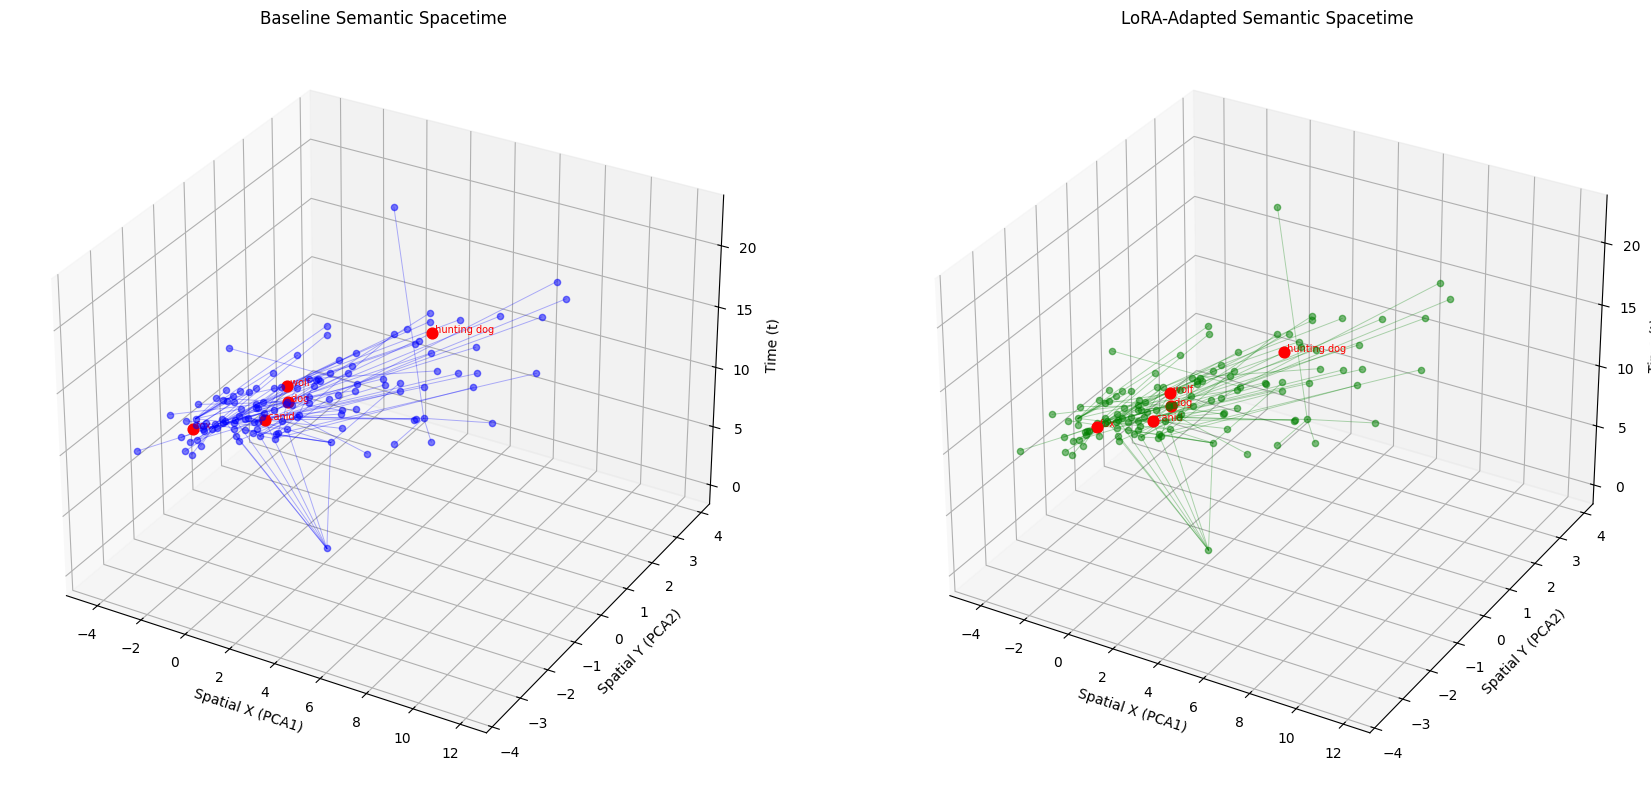


Comparing K-Nearest Neighbors for 'dog':
  In BASELINE (spacetime_euclidean):
    - Newfoundland (Dist: 0.034)
    - pooch (Dist: 0.236)
    - pug (Dist: 0.553)
    - wolf (Dist: 0.755)
    - genet (Dist: 0.777)
  In LoRA-ADAPTED (spacetime_euclidean):
    - Newfoundland (Dist: 0.099)
    - pooch (Dist: 0.130)
    - wolf (Dist: 0.589)
    - pug (Dist: 0.616)
    - canid (Dist: 0.753)
  Task-relevant neighbors (excluding self) in BASELINE KNN: 1/5
  Task-relevant neighbors (excluding self) in LoRA KNN: 2/5
  Observation: More task-relevant concepts are closer in LoRA-adapted space.


In [ ]:
# @title Adapting our Semantic embeddings with LoRA to improve accuracy on a particular topic Focus!
import nltk
from nltk.corpus import wordnet as wn
import torch
from transformers import BertTokenizer, BertModel
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import random
import matplotlib.pyplot as plt

print(
    "\n=== Demo: Comparing Baseline vs. Simulated LoRA-Adapted Semantic Spacetime ==="
)
# --- 1. Initial Data Setup (Same as WordNet BERT demo) -------------------------------------
print("\nLoading concepts and generating baseline BERT embeddings...")
# Let's use a slightly larger, more complex subtree for this demo
# e.g., carnivore subtree, or placental with a bit more depth
wordnet_subtree_data = get_mammal_concepts(
    depth_limit=3, start_synset_name="carnivore.n.01"
)
if not wordnet_subtree_data:
    print("Failed to load WordNet concepts. Exiting demo.")
    # exit()
    pass

baseline_bert_embeddings = {}
for name in wordnet_subtree_data.keys():
    emb = get_bert_embedding(name, bert_model, tokenizer)
    if emb is not None:
        baseline_bert_embeddings[name] = emb.tolist()

# Filter data to only include concepts with embeddings
wordnet_subtree_data = {
    name: data
    for name, data in wordnet_subtree_data.items()
    if name in baseline_bert_embeddings
}
valid_concept_names = list(wordnet_subtree_data.keys())
print(f"Using {len(valid_concept_names)} concepts with baseline BERT embeddings.")

# Construct hierarchy
baseline_hierarchy_pairs = []
baseline_root_name = None
if wordnet_subtree_data:
    min_depth_wn = float("inf")
    for name, data in wordnet_subtree_data.items():
        if not data["parents"] and name in baseline_bert_embeddings:
            if data["depth"] <= min_depth_wn:
                min_depth_wn = data["depth"]
                baseline_root_name = name
        for parent_name in data["parents"]:
            if (
                parent_name in baseline_bert_embeddings
                and name in baseline_bert_embeddings
            ):
                baseline_hierarchy_pairs.append((name, parent_name))
    if baseline_root_name:
        baseline_hierarchy_pairs.append((baseline_root_name, None))
    # (Add more robust root finding if needed, similar to previous demo)
    baseline_hierarchy_pairs = sorted(list(set(baseline_hierarchy_pairs)))
print(
    f"Constructed baseline hierarchy with {len(baseline_hierarchy_pairs)} pairs. Root: {baseline_root_name}"
)


# --- 2. Compute Baseline Minkowski Embedding ------------------------------------------------------------------
spatial_dims = 2
epsilon = 1e-5

print("\nComputing BASELINE Minkowski Embedding...")
baseline_minkowski_coords = {}
if baseline_bert_embeddings and baseline_hierarchy_pairs:
    baseline_minkowski_coords = compute_minkowski_embedding(
        baseline_bert_embeddings, baseline_hierarchy_pairs, spatial_dims, epsilon
    )
    print(f"Computed {len(baseline_minkowski_coords)} baseline Minkowski coordinates.")
else:
    print("Skipping baseline embedding due to missing data.")


# --- 3. Define a "Task Focus" and Simulate LoRA Adaptation -----------------------------------------------------
TASK_FOCUS_CONCEPTS = [
    "dog",
    "wolf",
    "fox",
    "canid",
    "hunting dog",
    "hound",
]  # Example: Focus on canids
# Filter to concepts actually present in our dataset
task_relevant_concepts = [
    name for name in TASK_FOCUS_CONCEPTS if name in baseline_bert_embeddings
]

print(f"\nSimulating LoRA adaptation with focus on: {task_relevant_concepts}")

adapted_bert_embeddings = {
    name: np.array(emb).copy() for name, emb in baseline_bert_embeddings.items()
}

if task_relevant_concepts:
    # Calculate centroid of task-relevant concepts in BERT space
    relevant_embeddings_matrix = np.array(
        [adapted_bert_embeddings[name] for name in task_relevant_concepts]
    )
    if (
        relevant_embeddings_matrix.ndim > 1 and relevant_embeddings_matrix.shape[0] > 0
    ):  # Check if matrix is not empty
        task_centroid = np.mean(relevant_embeddings_matrix, axis=0)

        ADAPTATION_STRENGTH = 0.2  # How much to pull towards centroid (0 to 1)

        for name, emb in adapted_bert_embeddings.items():
            if name in task_relevant_concepts:
                # Pull relevant concepts slightly towards the task centroid
                adapted_bert_embeddings[name] = (
                    emb * (1 - ADAPTATION_STRENGTH)
                    + task_centroid * ADAPTATION_STRENGTH
                )
            # else:
            # Optionally, push non-relevant concepts slightly away, or leave them
            # direction_away = emb - task_centroid
            # adapted_bert_embeddings[name] = emb + direction_away * (ADAPTATION_STRENGTH * 0.1) # Push away less strongly
    else:
        print(
            "No relevant embeddings found for task focus, skipping adaptation simulation."
        )

# Convert back to list for the embedding function
adapted_bert_embeddings_list = {
    name: emb.tolist() for name, emb in adapted_bert_embeddings.items()
}

# --- 4. Compute "LoRA-Adapted" Minkowski Embedding -----------------------------------------------------------
# Using the SAME hierarchy_pairs but with adapted_bert_embeddings
print("\nComputing LoRA-ADAPTED Minkowski Embedding...")
lora_minkowski_coords = {}
if adapted_bert_embeddings_list and baseline_hierarchy_pairs:  # Use baseline hierarchy
    lora_minkowski_coords = compute_minkowski_embedding(
        adapted_bert_embeddings_list, baseline_hierarchy_pairs, spatial_dims, epsilon
    )
    print(f"Computed {len(lora_minkowski_coords)} LoRA-adapted Minkowski coordinates.")
else:
    print("Skipping LoRA-adapted embedding due to missing data.")

# --- 5. Comparison ---------------------------------------------------------------------------------


# A. Visual Comparison (Plot both side-by-side or overlaid if desired)
def plot_minkowski_embedding(
    coords, hierarchy, title, ax, color="blue", highlight_nodes=None
):
    if not coords:
        return
    highlight_nodes = highlight_nodes or []

    if spatial_dims == 2:
        ax.set_xlabel("Spatial X (PCA1)")
        ax.set_ylabel("Spatial Y (PCA2)")
        ax.set_zlabel("Time (t)")
        link_indices = (1, 2, 0)
    elif spatial_dims == 1:
        ax.set_xlabel("Spatial X (PCA1)")
        ax.set_ylabel("Time (t)")
        link_indices = (1, 0)
    else:
        return  # Should not happen

    for name, c_val in coords.items():
        plot_args_scatter = [c_val[i] for i in link_indices]
        point_color = "red" if name in highlight_nodes else color
        point_size = 60 if name in highlight_nodes else 20
        point_alpha = 1.0 if name in highlight_nodes else 0.5
        ax.scatter(*plot_args_scatter, c=point_color, s=point_size, alpha=point_alpha)
        if len(coords) < 30 or name in highlight_nodes:
            ax.text(
                *plot_args_scatter,
                f" {name}",
                fontsize=7,
                color=point_color if name in highlight_nodes else "black",
            )

    for child, parent in hierarchy:
        if parent is None or child not in coords or parent not in coords:
            continue
        p1c, p2c = coords[parent], coords[child]
        plot_args_line = []
        for i_dim_plot in range(len(link_indices)):
            actual_idx = link_indices[i_dim_plot]
            plot_args_line.extend([[p1c[actual_idx], p2c[actual_idx]]])
        ax.plot(*plot_args_line, c=color, alpha=0.3, linewidth=0.7)
    ax.set_title(title)


if baseline_minkowski_coords and lora_minkowski_coords:
    print("\nVisualizing Baseline vs. LoRA-Adapted Spacetimes...")
    fig_compare = plt.figure(figsize=(18, 8))
    if spatial_dims == 2:
        ax_base = fig_compare.add_subplot(121, projection="3d")
        ax_lora = fig_compare.add_subplot(122, projection="3d")
    elif spatial_dims == 1:
        ax_base = fig_compare.add_subplot(121)
        ax_lora = fig_compare.add_subplot(122)
    else:  # Should not occur with spatial_dims=1 or 2
        print("Cannot plot for current spatial_dims setting.")
        # exit()

    plot_minkowski_embedding(
        baseline_minkowski_coords,
        baseline_hierarchy_pairs,
        "Baseline Semantic Spacetime",
        ax_base,
        color="blue",
        highlight_nodes=task_relevant_concepts,
    )
    plot_minkowski_embedding(
        lora_minkowski_coords,
        baseline_hierarchy_pairs,  # Use same hierarchy
        "LoRA-Adapted Semantic Spacetime",
        ax_lora,
        color="green",
        highlight_nodes=task_relevant_concepts,
    )
    plt.tight_layout()
    plt.show()

# B. Compare Path Actions
# Pick a path that involves some of the TASK_FOCUS_CONCEPTS
# Example path: carnivore -> canid -> dog (if these are in your subtree)
path_to_analyze = []
if (
    baseline_root_name == "carnivore"
    and "canid" in parent_to_children_map.get("carnivore", [])
    and "dog" in parent_to_children_map.get("canid", [])
):
    path_to_analyze = ["carnivore", "canid", "dog"]
elif task_relevant_concepts and len(task_relevant_concepts) >= 2:
    # Try to find a simple path involving first two relevant concepts if one is parent of other
    c1, c2 = task_relevant_concepts[0], task_relevant_concepts[1]
    if any(p == c1 and c == c2 for c, p in baseline_hierarchy_pairs):
        path_to_analyze = [c1, c2]
    elif any(p == c2 and c == c1 for c, p in baseline_hierarchy_pairs):
        path_to_analyze = [c2, c1]


if (
    path_to_analyze
    and baseline_minkowski_coords
    and lora_minkowski_coords
    and all(n in baseline_bert_embeddings for n in path_to_analyze)
    and all(n in adapted_bert_embeddings_list for n in path_to_analyze)
):  # Ensure adapted embeddings exist too
    print(f"\nComparing action for path: {' -> '.join(path_to_analyze)}")

    action_baseline, _ = calculate_euclidean_action_with_potential(
        path_to_analyze, baseline_minkowski_coords, baseline_bert_embeddings
    )
    action_lora, _ = calculate_euclidean_action_with_potential(
        path_to_analyze,
        lora_minkowski_coords,
        adapted_bert_embeddings_list,  # Use adapted BERT for LoRA action
    )
    print(f"  Action in BASELINE spacetime: {action_baseline:.4f}")
    print(f"  Action in LoRA-ADAPTED spacetime: {action_lora:.4f}")
    if action_lora < action_baseline:
        print(
            "  Observation: Path action DECREASED in LoRA-adapted space (path became 'easier')."
        )
    elif action_lora > action_baseline:
        print("  Observation: Path action INCREASED in LoRA-adapted space.")
    else:
        print("  Observation: Path action remained similar.")

# C. Compare K-Nearest Neighbors for a task-relevant concept
if task_relevant_concepts and baseline_minkowski_coords and lora_minkowski_coords:
    query_concept_lora = task_relevant_concepts[0]
    k_lora = 5

    print(f"\nComparing K-Nearest Neighbors for '{query_concept_lora}':")

    print("  In BASELINE (spacetime_euclidean):")
    knn_base = find_k_nearest_concepts(
        query_concept_lora, baseline_minkowski_coords, k_lora, "spacetime_euclidean"
    )
    for name, dist in knn_base:
        print(f"    - {name} (Dist: {dist:.3f})")

    print("  In LoRA-ADAPTED (spacetime_euclidean):")
    knn_lora = find_k_nearest_concepts(
        query_concept_lora, lora_minkowski_coords, k_lora, "spacetime_euclidean"
    )
    for name, dist in knn_lora:
        print(f"    - {name} (Dist: {dist:.3f})")

    # Are more task-relevant concepts appearing as neighbors in LoRA space?
    base_relevant_neighbors = sum(
        1
        for name, _ in knn_base
        if name in task_relevant_concepts and name != query_concept_lora
    )
    lora_relevant_neighbors = sum(
        1
        for name, _ in knn_lora
        if name in task_relevant_concepts and name != query_concept_lora
    )
    print(
        f"  Task-relevant neighbors (excluding self) in BASELINE KNN: {base_relevant_neighbors}/{k_lora}"
    )
    print(
        f"  Task-relevant neighbors (excluding self) in LoRA KNN: {lora_relevant_neighbors}/{k_lora}"
    )
    if lora_relevant_neighbors > base_relevant_neighbors:
        print(
            "  Observation: More task-relevant concepts are closer in LoRA-adapted space!"
        )

else:
    print(
        "Skipping detailed comparison due to missing data for baseline or LoRA embeddings."
    )

Generating BERT embeddings for target concepts...

--- Attempting to 'Imagine' the concept: dog ---

Searching for compositional path to 'dog'...
  Step 0: New best match 'num_legs_4' (h_score=9.696, g_score=0.00)
Search ended after 5000 steps. Best match found:

--- 'Imagined' Composition for 'dog' ---
Final Composed Name: num_legs_4
Final Features: frozenset({'property_num_legs_4'})
Final Intel Coord (tau, x, y): [0.00, -0.60, -0.90]
Construction Cost (g_score): 0.00
Construction Path (sequence of concepts and tasks):


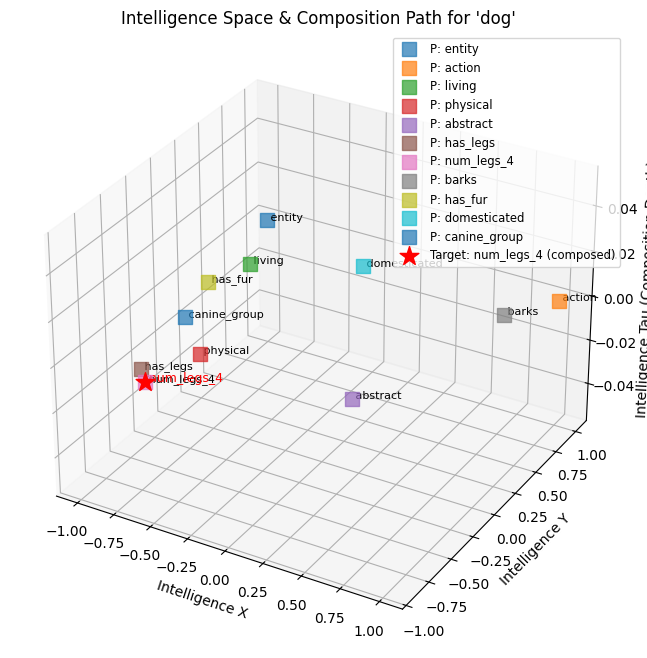

In [ ]:
# @title 'Imagining' Concepts using Embeddings!
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import matplotlib.pyplot as plt

# --- 1. Define Semantic Primitives (Our Low-Dimensional "Intelligence" Space) ---
# Each primitive has a name, a set of inherent features, and a simple low-D vector
# For this demo, let our "intelligence space" be 2D (x_intel, y_intel)
# We can also assign a base "tau_intel" representing fundamental level.
PRIMITIVE_TAU = 0.0

semantic_primitives = {
    "entity": {"features": {"is_entity"}, "intel_coord": [PRIMITIVE_TAU, -1.0, 1.0]},
    "action": {"features": {"is_action"}, "intel_coord": [PRIMITIVE_TAU, 1.0, 1.0]},
    "living": {"features": {"is_living"}, "intel_coord": [PRIMITIVE_TAU, -0.8, 0.5]},
    "physical": {
        "features": {"is_physical"},
        "intel_coord": [PRIMITIVE_TAU, -0.5, -0.5],
    },
    "abstract": {
        "features": {"is_abstract"},
        "intel_coord": [PRIMITIVE_TAU, 0.5, -0.5],
    },
    "has_legs": {
        "features": {"property_has_legs"},
        "intel_coord": [PRIMITIVE_TAU, -0.7, -0.8],
    },  # General property
    "num_legs_4": {
        "features": {"property_num_legs_4"},
        "intel_coord": [PRIMITIVE_TAU, -0.6, -0.9],
    },  # Specific value
    "barks": {"features": {"action_barks"}, "intel_coord": [PRIMITIVE_TAU, 0.8, 0.7]},
    "has_fur": {
        "features": {"property_has_fur"},
        "intel_coord": [PRIMITIVE_TAU, -0.9, 0.2],
    },
    "domesticated": {
        "features": {"state_domesticated"},
        "intel_coord": [PRIMITIVE_TAU, -0.2, 0.8],
    },
    "canine_group": {
        "features": {"group_canine"},
        "intel_coord": [PRIMITIVE_TAU, -0.8, -0.2],
    },  # A primitive "grouping"
}

# --- 2. Target Concepts (from "Experience" - BERT embeddings) ---
target_concept_names = ["dog", "cat", "wolf", "animal", "mammal", "pet"]
target_concept_bert_embeddings = {}
print("Generating BERT embeddings for target concepts...")
for name in target_concept_names:
    emb = get_bert_embedding(name, bert_model, tokenizer)
    if emb is not None:
        target_concept_bert_embeddings[name] = emb
    else:
        print(f"Warning: Could not get BERT embedding for '{name}'")

if not target_concept_bert_embeddings:
    print("No target BERT embeddings. Demo cannot proceed effectively.")
    # exit()
    pass

# --- 3. Define Compositional Tasks (Rules of "Semantic Physics") ---
# A task takes one or two existing composed concepts (or primitives) and creates a new one.
# Output: new_name, new_features, new_intel_coord (e.g., average), cost_of_composition

compositional_tasks = []


def define_composition(
    name: str,
    concept1_name_pattern: str,
    concept2_name_pattern: str,
    output_name_template: str,
    cost: float = 1.0,
):
    """
    Defines a template for a compositional task.
    name_pattern can be a specific name or "*" to match any.
    """
    compositional_tasks.append(
        {
            "name": name,
            "c1_pattern": concept1_name_pattern,
            "c2_pattern": concept2_name_pattern,  # If None, it's a unary modification/specialization
            "output_template": output_name_template,
            "cost": cost,
        }
    )


# Examples of compositional rules:
# Rule 1: Combine an entity with a property
define_composition("AddProperty", "*", "property_*", "{c1}_with_{c2_feature}", cost=1.0)
# Rule 2: Combine two entities/groups if one is a known sub-group (very simplified)
define_composition(
    "SpecializeGroup", "*", "group_*", "{c2_feature}_{c1}", cost=0.8
)  # e.g. canine_animal
# Rule 3: Combine an entity with an action it performs
define_composition(
    "EntityPerformsAction", "*", "action_*", "{c1}_that_{c2_feature}", cost=1.2
)
# Rule 4: Combine two existing composed states (more general)
define_composition("MergeStates", "*", "*", "merged_{c1}_and_{c2}", cost=1.5)
# Rule 5: Simple inheritance/typing (unary)
define_composition("AssignType_Living", "entity", None, "living_entity", cost=0.5)
define_composition("AssignType_Physical", "entity", None, "physical_entity", cost=0.5)
define_composition(
    "Specialize_Animal", "living_entity", None, "animal", cost=0.5
)  # if 'living_entity' has certain features

# This is a very small set. A real system would have many more, or learn them.

# Represent current state for A* search:
# (f_score, g_score, current_concept_name, current_features_set, current_intel_coord, path_list)
# Our "composed concepts" will be dynamically named for this demo.


class ComposedConcept:
    def __init__(self, name, features, intel_coord, construction_cost, path):
        self.name = name
        self.features = frozenset(features)  # Use frozenset for hashability
        self.intel_coord = tuple(intel_coord)  # Use tuple for hashability
        self.cost = construction_cost
        self.path = path  # List of task names and concept names

    def __lt__(self, other):  # For heapq
        return self.cost < other.cost  # Could be f_score if doing proper A*

    def __hash__(self):
        return hash((self.name, self.features, self.intel_coord))

    def __eq__(self, other):
        return (
            isinstance(other, ComposedConcept)
            and self.name == other.name
            and self.features == other.features
            and self.intel_coord == other.intel_coord
        )

    def __repr__(self):
        return f"Composed('{self.name}', cost={self.cost:.2f}, intel_coord=({self.intel_coord[1]:.2f},{self.intel_coord[2]:.2f}))"


# --- 4. "Imagination" / Search Process (A* to find compositional path to target BERT embedding) -------------------------------------


def get_pseudo_bert_from_features(features_set, all_primitives_bert_like_vectors):
    """
    Crude way to get a BERT-like vector for a composed concept:
    Average BERT vectors of primitives whose features are present.
    In reality, this mapping would be complex and learned.
    For demo, we'll use this to calculate heuristic distance to target BERT.
    """
    active_primitive_vectors = []
    for p_name, p_data in semantic_primitives.items():
        if p_data["features"].issubset(features_set):  # or any overlap
            # We need BERT-like vectors for primitives if we want to average them.
            # Let's create placeholder "primitive BERTs" by averaging target BERTs they might relate to
            if p_name in all_primitives_bert_like_vectors:
                active_primitive_vectors.append(
                    all_primitives_bert_like_vectors[p_name]
                )

    if not active_primitive_vectors:
        return np.zeros_like(
            list(target_concept_bert_embeddings.values())[0]
        )  # Zero vector if no match
    return np.mean(active_primitive_vectors, axis=0)


# Pre-calculate pseudo-BERT for primitives for heuristic (highly simplified)
# A better way would be to have actual embeddings for primitives or learn a projection
primitive_pseudo_berts = {}
if target_concept_bert_embeddings:  # Ensure this is not empty
    example_bert_dim = len(list(target_concept_bert_embeddings.values())[0])
    for p_name in semantic_primitives:
        # Simplistic: associate primitives with target concepts they might be part of
        # This is just to get *some* vector for the heuristic
        related_target_sum = np.zeros(example_bert_dim)
        count = 0
        for t_name, t_emb in target_concept_bert_embeddings.items():
            if any(
                f_part in t_name for f_part in semantic_primitives[p_name]["features"]
            ):
                related_target_sum += t_emb
                count += 1
        primitive_pseudo_berts[p_name] = (
            related_target_sum / count
            if count > 0
            else np.random.rand(example_bert_dim) * 0.1
        )


def heuristic_to_target_bert(
    composed_features, target_bert_embedding, primitive_berts_for_heuristic
):
    if not target_concept_bert_embeddings:
        return float("inf")  # Should not happen if checked before

    composed_pseudo_bert = get_pseudo_bert_from_features(
        composed_features, primitive_berts_for_heuristic
    )
    # Cosine distance = 1 - cosine_similarity
    similarity = cosine_similarity(
        composed_pseudo_bert.reshape(1, -1), target_bert_embedding.reshape(1, -1)
    )[0, 0]
    return (1.0 - similarity) * 10  # Scaled distance as heuristic (lower is better)


def find_compositional_path(target_concept_name_str: str, max_steps=5000):
    if target_concept_name_str not in target_concept_bert_embeddings:
        print(f"Target concept '{target_concept_name_str}' has no BERT embedding.")
        return None

    target_bert = target_concept_bert_embeddings[target_concept_name_str]

    # Start with all primitives as initial composed concepts
    open_set = []  # (f_score, ComposedConcept_object)
    for p_name, p_data in semantic_primitives.items():
        intel_coord_p = p_data["intel_coord"]  # [tau, x, y]
        # Ensure intel_coord_p is a list of numbers
        if not all(isinstance(val, (int, float)) for val in intel_coord_p):
            print(
                f"Warning: Primitive '{p_name}' has invalid intel_coord: {intel_coord_p}. Skipping."
            )
            continue

        concept = ComposedConcept(
            p_name, p_data["features"], intel_coord_p, 0, [p_name]
        )
        h_score = heuristic_to_target_bert(
            concept.features, target_bert, primitive_pseudo_berts
        )
        heapq.heappush(open_set, (0 + h_score, concept))

    closed_set = (
        set()
    )  # Store (name, features_frozenset, intel_coord_tuple) of visited states

    print(f"\nSearching for compositional path to '{target_concept_name_str}'...")

    best_match_so_far = (
        float("inf"),
        None,
    )  # (distance_to_target_bert, concept_object)

    for step_count in range(max_steps):
        if not open_set:
            print("Open set empty, search ended.")
            break

        f_score, current_composed_concept = heapq.heappop(open_set)

        # Check if this concept is a good match (using heuristic for now)
        # A better match would involve projecting its low-D intel_coord to BERT space and comparing
        current_h_score = heuristic_to_target_bert(
            current_composed_concept.features, target_bert, primitive_pseudo_berts
        )
        if current_h_score < best_match_so_far[0]:
            best_match_so_far = (current_h_score, current_composed_concept)
            print(
                f"  Step {step_count}: New best match '{current_composed_concept.name}' (h_score={current_h_score:.3f}, g_score={current_composed_concept.cost:.2f})"
            )

        if current_h_score < 0.5:  # Arbitrary threshold for "good enough" match
            print(f"Found good match for '{target_concept_name_str}'!")
            return current_composed_concept

        state_signature = (
            current_composed_concept.name,
            current_composed_concept.features,
            current_composed_concept.intel_coord,
        )
        if state_signature in closed_set:
            continue
        closed_set.add(state_signature)

        # Try to apply compositional tasks
        # Unary tasks (modifications)
        for task_template in compositional_tasks:
            if task_template["c2_pattern"] is None:  # Unary task
                if (
                    task_template["c1_pattern"] == "*"
                    or task_template["c1_pattern"] == current_composed_concept.name
                ):
                    new_name = task_template["output_template"].format(
                        c1=current_composed_concept.name
                    )
                    # Unary tasks usually add/refine features or specialize type
                    new_features = set(
                        current_composed_concept.features
                    )  # Start with current features
                    # Example: if task is AssignType_Living, add 'is_living' if 'entity' is present
                    if (
                        task_template["name"] == "AssignType_Living"
                        and "is_entity" in new_features
                    ):
                        new_features.add("is_living")
                    elif (
                        task_template["name"] == "Specialize_Animal"
                        and "is_living_entity" in new_features
                    ):  # Assume "living_entity" is a composed name
                        new_features.add(
                            "is_animal_group_feature"
                        )  # Add a marker feature
                    # Add more specific unary task logic here...

                    # New intel_coord: could be same or slightly shifted
                    new_intel_coord_list = list(current_composed_concept.intel_coord)
                    new_intel_coord_list[0] += (
                        0.1  # Increment tau_intel slightly for new composition step
                    )
                    # Simple shift for demo for unary op
                    new_intel_coord_list[1] += random.uniform(-0.05, 0.05)
                    new_intel_coord_list[2] += random.uniform(-0.05, 0.05)

                    new_concept = ComposedConcept(
                        new_name,
                        new_features,
                        new_intel_coord_list,
                        current_composed_concept.cost + task_template["cost"],
                        current_composed_concept.path
                        + [task_template["name"], new_name],
                    )

                    if (
                        new_concept.name,
                        new_concept.features,
                        new_concept.intel_coord,
                    ) not in closed_set:
                        h = heuristic_to_target_bert(
                            new_concept.features, target_bert, primitive_pseudo_berts
                        )
                        heapq.heappush(open_set, (new_concept.cost + h, new_concept))

        # Binary tasks (compositions with other primitives or already composed concepts)
        # For simplicity, let's compose with primitives only in this demo A* step
        for p_name, p_data in semantic_primitives.items():
            primitive_concept = ComposedConcept(
                p_name, p_data["features"], p_data["intel_coord"], 0, [p_name]
            )  # Cost 0 for primitive itself

            for task_template in compositional_tasks:
                if task_template["c2_pattern"] is not None:  # Binary task
                    # Check if current_composed_concept matches c1_pattern and primitive_concept matches c2_pattern
                    # (Simplified matching for demo)
                    c1_match = (
                        task_template["c1_pattern"] == "*"
                        or task_template["c1_pattern"] == current_composed_concept.name
                    )
                    c2_match = (
                        task_template["c2_pattern"] == "*"
                        or (
                            task_template["c2_pattern"].startswith("property_")
                            and any(
                                f.startswith("property_")
                                for f in primitive_concept.features
                            )
                        )
                        or (
                            task_template["c2_pattern"].startswith("group_")
                            and any(
                                f.startswith("group_")
                                for f in primitive_concept.features
                            )
                        )
                        or (
                            task_template["c2_pattern"].startswith("action_")
                            and any(
                                f.startswith("action_")
                                for f in primitive_concept.features
                            )
                        )
                    )

                    if c1_match and c2_match:
                        # Create new composed concept
                        new_name = task_template["output_template"].format(
                            c1=current_composed_concept.name,
                            c2=primitive_concept.name,  # Or a feature from it
                            c1_feature=list(current_composed_concept.features)[0]
                            if current_composed_concept.features
                            else "feature1",
                            c2_feature=list(primitive_concept.features)[0]
                            if primitive_concept.features
                            else "feature2",
                        )
                        new_features = current_composed_concept.features.union(
                            primitive_concept.features
                        )

                        # New intel_coord: average of parents, tau slightly increased
                        new_intel_coord_list = [
                            max(
                                current_composed_concept.intel_coord[0],
                                primitive_concept.intel_coord[0],
                            )
                            + 0.2,  # Higher tau
                            (
                                current_composed_concept.intel_coord[1]
                                + primitive_concept.intel_coord[1]
                            )
                            / 2
                            + random.uniform(-0.05, 0.05),
                            (
                                current_composed_concept.intel_coord[2]
                                + primitive_concept.intel_coord[2]
                            )
                            / 2
                            + random.uniform(-0.05, 0.05),
                        ]

                        new_concept = ComposedConcept(
                            new_name,
                            new_features,
                            new_intel_coord_list,
                            current_composed_concept.cost
                            + primitive_concept.cost
                            + task_template["cost"],
                            current_composed_concept.path
                            + [primitive_concept.name, task_template["name"], new_name],
                        )

                        state_sig_new = (
                            new_concept.name,
                            new_concept.features,
                            new_concept.intel_coord,
                        )
                        if state_sig_new not in closed_set:
                            h = heuristic_to_target_bert(
                                new_concept.features,
                                target_bert,
                                primitive_pseudo_berts,
                            )
                            heapq.heappush(
                                open_set, (new_concept.cost + h, new_concept)
                            )

    print(f"Search ended after {max_steps} steps. Best match found:")
    return best_match_so_far[1]


# --- Run the Demo ---
if target_concept_bert_embeddings:
    target_to_explain = "dog"  # Choose one of the target_concept_names

    print(f"\n--- Attempting to 'Imagine' the concept: {target_to_explain} ---")
    explained_concept_path = find_compositional_path(target_to_explain)

    if explained_concept_path:
        print(f"\n--- 'Imagined' Composition for '{target_to_explain}' ---")
        print(f"Final Composed Name: {explained_concept_path.name}")
        print(f"Final Features: {explained_concept_path.features}")
        print(
            f"Final Intel Coord (tau, x, y): [{explained_concept_path.intel_coord[0]:.2f}, {explained_concept_path.intel_coord[1]:.2f}, {explained_concept_path.intel_coord[2]:.2f}]"
        )
        print(f"Construction Cost (g_score): {explained_concept_path.cost:.2f}")
        print("Construction Path (sequence of concepts and tasks):")
        current_segment = []
        for item in explained_concept_path.path:
            current_segment.append(item)
            if len(current_segment) == 3 or (
                len(current_segment) == 2
                and item
                in [t["name"] for t in compositional_tasks if t["c2_pattern"] is None]
            ):  # Primitive, Task, NewConcept OR Primitive/Composed, UnaryTask
                print(f"  {' -> '.join(current_segment)}")
                # Start new segment with the last concept if it's not a task name
                if not any(item == t["name"] for t in compositional_tasks):
                    current_segment = [item]
                else:  # if last item was task name, then the "new_name" was already printed.
                    current_segment = []

        # --- Visualization of the "Intelligence Space" and the composed path ---
        fig_intel = plt.figure(figsize=(10, 8))
        ax_intel = fig_intel.add_subplot(
            111,
            projection="3d"
            if len(
                semantic_primitives[list(semantic_primitives.keys())[0]]["intel_coord"]
            )
            == 3
            else None,
        )

        # Plot primitives
        for p_name, p_data in semantic_primitives.items():
            coord = p_data["intel_coord"]
            if len(coord) == 3:  # tau, x, y
                ax_intel.scatter(
                    coord[1],
                    coord[2],
                    coord[0],
                    marker="s",
                    s=100,
                    label=f"P: {p_name}",
                    alpha=0.7,
                )
                ax_intel.text(coord[1], coord[2], coord[0], f" {p_name}", fontsize=8)
            elif len(coord) == 2:  # x,y (assuming tau is 0 or not plotted)
                ax_intel.scatter(
                    coord[0],
                    coord[1],
                    marker="s",
                    s=100,
                    label=f"P: {p_name}",
                    alpha=0.7,
                )
                ax_intel.text(coord[0], coord[1], f" {p_name}", fontsize=8)

        # Plot the composed path
        # Path contains names. We need to reconstruct coords. This is tricky as composed coords are dynamic.
        # For this demo, let's just plot the final composed concept if its intel_coord is available.
        final_intel_coord = explained_concept_path.intel_coord
        if len(final_intel_coord) == 3:
            ax_intel.scatter(
                final_intel_coord[1],
                final_intel_coord[2],
                final_intel_coord[0],
                marker="*",
                s=200,
                color="red",
                label=f"Target: {explained_concept_path.name} (composed)",
            )
            ax_intel.text(
                final_intel_coord[1],
                final_intel_coord[2],
                final_intel_coord[0],
                f" {explained_concept_path.name}",
                fontsize=9,
                color="red",
            )
            ax_intel.set_xlabel("Intelligence X")
            ax_intel.set_ylabel("Intelligence Y")
            ax_intel.set_zlabel("Intelligence Tau (Composition Depth)")

        elif len(final_intel_coord) == 2:
            ax_intel.scatter(
                final_intel_coord[0],
                final_intel_coord[1],
                marker="*",
                s=200,
                color="red",
                label=f"Target: {explained_concept_path.name} (composed)",
            )
            ax_intel.text(
                final_intel_coord[0],
                final_intel_coord[1],
                f" {explained_concept_path.name}",
                fontsize=9,
                color="red",
            )
            ax_intel.set_xlabel("Intelligence X")
            ax_intel.set_ylabel("Intelligence Y")

        plt.title(f"Intelligence Space & Composition Path for '{target_to_explain}'")
        plt.legend(fontsize="small")
        plt.show()

    else:
        print(
            f"Could not 'imagine' a good compositional path for '{target_to_explain}'."
        )
else:
    print("Demo requires target_concept_bert_embeddings to be populated.")

# Application: Git Commit Graphs!
Every Git Repo Commit graph is a DAG, we can easily answer questions like "can I rebase to this commit?" in $O(1)$ time complexity even in large repos!

In [ ]:
!pip install gitpython
# Trying a really LARGE REPO!
!git clone https://github.com/llvm/llvm-project.git
# !git clone https://github.com/gitpython-developers/GitPython.git
# OR a repo with known interesting history if you have one.
# Set the repo_path in your Python script
repo_path_colab = "llvm-project"  # Or "GitPython" or the name of the cloned folder

Cloning into 'llvm-project'...
remote: Enumerating objects: 6547545, done.
remote: Counting objects: 100% (4729/4729), done.
remote: Compressing objects: 100% (1619/1619), done.
remote: Total 6547545 (delta 4157), reused 3120 (delta 3110), pack-reused 6542816 (from 3)
Receiving objects: 100% (6547545/6547545), 2.03 GiB | 18.53 MiB/s, done.
Resolving deltas: 100% (5423132/5423132), done.
Updating files: 100% (157705/157705), done.


In [ ]:
# @title Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import time
import git  # For GitPython

# @title Provided Convergence Function (Enforcing Δt_parent-child > ||Δx||)
# This function expects t_child < t_parent for the delta_t calculation
# delta_t = time_vec[p] - time_vec[c]  (t_parent - t_child)


def project_until_convergence(
    pairs: torch.LongTensor,
    spatial: torch.Tensor,
    time_vec: torch.Tensor,
    eps1: float = 1e-5,
    max_passes: int = 10000,
) -> int:
    """Deterministically enforce `Δt_parent-child > ||Δx||` by shifting *only* `t`.

    Modifies time_vec in place.
    Assumes pairs are [child_idx, parent_idx].
    We want t_parent > t_child for the paper's causality interpretation.
    The function will adjust t_parent and t_child to satisfy:
    (t_parent - t_child) > ||spatial_parent - spatial_child|| + eps1

    Returns the number of full passes executed until convergence.
    """
    for n_pass in range(1, max_passes + 1):
        c_indices = pairs[:, 0]  # child indices
        p_indices = pairs[:, 1]  # parent indices

        # Δt = t_parent - t_child
        delta_t = time_vec[p_indices] - time_vec[c_indices]
        # ||Δx|| = ||spatial_parent - spatial_child||
        delta_space_norm = (spatial[p_indices] - spatial[c_indices]).norm(dim=1)

        # Violation: delta_t <= delta_space_norm + eps1
        violation = (
            delta_t <= delta_space_norm + eps1
        )  # Note: The original notebook's logic was inverted for t_child > t_parent

        if not violation.any():
            print(f"Converged after {n_pass} passes.")
            return n_pass

        # Calculate the shift needed for the violating pairs
        # We want delta_t_new = delta_space_norm + eps1
        # needed_total_dt_increase = (delta_space_norm + eps1) - delta_t
        needed_shift_for_dt = delta_space_norm[violation] + eps1 - delta_t[violation]

        # Get the child and parent indices for the violating pairs
        c_bad = c_indices[violation]
        p_bad = p_indices[violation]

        # Count how many times each *child* index appears in c_bad
        # and each *parent* index appears in p_bad
        # This is a simplification: we'll shift parent and child equally.
        # A more sophisticated approach might consider node degrees or other factors.
        # For now, apply half the needed shift to parent (increase) and half to child (decrease)
        # to increase their temporal separation.
        # Inside project_until_convergence, at the end of the loop (or every N passes)
        # MAX_TIME_VALUE = 1e10
        # MIN_TIME_VALUE = -1e10
        # Clamp after update
        # time_vec.clamp_(MIN_TIME_VALUE, MAX_TIME_VALUE)
        # Check for NaNs (more critical if clamping doesn't prevent them upstream)
        if torch.isnan(time_vec).any():
            print(f"WARNING: NaN detected in time_vec during pass {n_pass}! Breaking.")
            # Consider saving problematic tensors/indices for debugging
            return max_passes + 2  # Indicate NaN failure
        if not violation.any():
            print(f"Converged after {n_pass} passes.")
            return n_pass
        share = needed_shift_for_dt / 2.0
        target_parent_t = time_vec[c_bad] + delta_space_norm[violation] + eps1
        shift_for_parent = target_parent_t - time_vec[p_bad]
        # Apply the updates:
        # Increase parent's time
        time_vec.index_add_(0, p_bad, shift_for_parent.to(time_vec.dtype))
        time_vec.index_add_(0, p_bad, share)
        # Decrease child's time (or keep it, and only increase parent, as per paper's eps2=0)
        # Let's try increasing parent and decreasing child to maximize separation effect
        time_vec.index_add_(0, c_bad, -share)

        if n_pass % (max_passes // 10 or 1) == 0:
            print(f"Pass {n_pass}: {violation.sum().item()} violations remaining.")

    print(
        f"Did not converge after {max_passes} passes. Violations: {violation.sum().item()}"
    )
    return max_passes + 1


# @title Visualization Function


def plot_embedding_git(
    coords_np, title, node_labels, edges_list_indices, labels_to_show=None
):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection="3d")

    ax.scatter(coords_np[:, 0], coords_np[:, 1], coords_np[:, 2], s=50)

    for c_idx, p_idx in edges_list_indices:
        ax.plot(
            coords_np[[p_idx, c_idx], 0],
            coords_np[[p_idx, c_idx], 1],
            coords_np[[p_idx, c_idx], 2],
            "gray",
            linestyle="-",
            linewidth=0.7,
            alpha=0.5,
        )

    if labels_to_show is None:  # Show all if not specified, or a sample if too many
        if len(node_labels) <= 30:
            labels_to_show = node_labels
        else:
            sample_indices = np.random.choice(
                len(node_labels), size=min(30, len(node_labels)), replace=False
            )
            labels_to_show = {i: node_labels[i] for i in sample_indices}

    for idx, label in labels_to_show.items():
        if idx < len(coords_np):  # Ensure index is valid
            ax.text(
                coords_np[idx, 0],
                coords_np[idx, 1],
                coords_np[idx, 2],
                label,
                color="black",
                fontsize=8,
                ha="right",
            )

    ax.set_xlabel("Spatial X1")
    ax.set_ylabel("Spatial X2")
    ax.set_zlabel("Time Coordinate (Adjusted)")
    ax.set_title(title)
    plt.show()


# @title Git Commit Graph Processing and Spacetime Embedding


def get_git_dag(repo_path, max_commits=100000, branch="main"):
    """
    Extracts commit history as a DAG.
    Returns: networkx.DiGraph, list of all nodes (commits), node_to_idx mapping, idx_to_node_sha mapping, pairs_list_indices, commit_objects_map
    """
    try:
        repo = git.Repo(repo_path)
    except git.exc.InvalidGitRepositoryError:
        print(f"Error: {repo_path} is not a valid Git repository.")
        return None, None, None, None, None, None

    G = nx.DiGraph()
    commits = list(repo.iter_commits(branch, max_count=max_commits))
    if not commits:
        print(f"No commits found in branch '{branch}' of repo '{repo_path}'.")
        return None, None, None, None, None, None

    # Node names will be short commit SHAs
    # We need a consistent ordering for node_to_idx
    # Process commits from oldest to newest for topological-like initial time
    commits.reverse()  # Oldest first

    commit_objects_map = {commit.hexsha: commit for commit in commits}
    all_nodes_sha = list(
        commit_objects_map.keys()
    )  # Ensure order matches commits.reverse() order
    node_to_idx = {sha: i for i, sha in enumerate(all_nodes_sha)}
    idx_to_node_sha = {i: sha for i, sha in enumerate(all_nodes_sha)}

    # Edges go from parent -> child (older -> newer commit)
    # For our algorithm, we need child -> parent pairs with t_parent > t_child
    pairs_list_indices = []

    for c_sha in all_nodes_sha:
        commit = commit_objects_map[c_sha]
        c_idx = node_to_idx[c_sha]
        G.add_node(
            c_sha, time=commit.committed_date, message=commit.message.split("\n")[0]
        )

        for parent in commit.parents:
            p_sha = parent.hexsha
            if p_sha in node_to_idx:  # Ensure parent is within our max_commits scope
                p_idx = node_to_idx[p_sha]
                G.add_edge(p_sha, c_sha)  # Graph edge: parent -> child
                pairs_list_indices.append(
                    [c_idx, p_idx]
                )  # For algorithm: child_idx, parent_idx

    return (
        G,
        all_nodes_sha,
        node_to_idx,
        idx_to_node_sha,
        pairs_list_indices,
        commit_objects_map,
    )


def assign_initial_coords_git(all_nodes_sha, node_to_idx, G, commit_objects_map):
    num_nodes = len(all_nodes_sha)
    # spatial_coords = np.random.rand(num_nodes, 2) * 10
    # spatial_coords = np.random.rand(num_nodes, 2) # Now in U(0,1)
    spatial_coords = (np.random.rand(num_nodes, 2) * 2) - 1  # Now in U(-1,1)

    # Initial time: Use commit timestamps, inverted so older commits have smaller 't' initially
    # The convergence algorithm expects t_parent > t_child.
    # Commit timestamps: newer commit has larger timestamp.
    # So, if t = commit_timestamp, then t_child > t_parent.
    # We need to flip this for the algorithm.
    # Let's assign levels based on topological sort (longest path from roots)
    # This naturally gives parents higher levels (later "time") if roots are t=0

    # Find roots within the loaded subgraph
    # A node is a root in the subgraph if it's a graph root (in_degree == 0)
    # OR if it has parents in the full history, but none of those parents are in the loaded all_nodes_sha list.
    subgraph_roots_sha = []
    for node_sha in all_nodes_sha:
        if G.in_degree(node_sha) == 0:  # Is a root in the extracted graph
            subgraph_roots_sha.append(node_sha)
        else:
            commit = commit_objects_map[node_sha]
            # Check if all its actual parents are outside the loaded subgraph
            if all(parent.hexsha not in node_to_idx for parent in commit.parents):
                subgraph_roots_sha.append(node_sha)

    if not G.nodes():  # Handle empty graph from get_git_dag if no commits
        return torch.empty(0, 2), torch.empty(0)

    # Get commit objects directly for timestamps
    # commit_objects_map is now passed in

    time_coords_raw = np.array(
        [commit_objects_map[sha].committed_date for sha in all_nodes_sha]
    )

    # Normalize and invert timestamps for initial 't' so parent > child
    # We need older commits (parents) to have SMALLER initial t, and newer (children) LARGER.
    # Then the algorithm pushes parent_t even larger than child_t.

    # Let's try: t = timestamp (newer = larger t).
    # The algorithm expects parent_t (older commit) > child_child (newer commit).
    # So we need to ensure that parents (older) are assigned a *numerically larger* initial time_vec value.
    # If using raw timestamps, older commit has smaller timestamp.
    # Strategy: Use topological sort order as a base for 't'
    # Nodes earlier in topological sort are "older" or "more ancestral"
    try:
        topo_sorted_nodes = list(nx.topological_sort(G))
        level_map = {node_sha: i for i, node_sha in enumerate(topo_sorted_nodes)}
        # Parents should have HIGHER 't'
        # If topo sort gives A->B->C, then level(A)=0, level(B)=1, level(C)=2
        # We want t(A) > t(B) > t(C). So t = max_level - level.
        max_level = len(topo_sorted_nodes) - 1
        # Ensure all_nodes_sha aligns with topo_sorted_nodes or adjust indexing
        # Since all_nodes_sha is already sorted oldest->newest by commit date (roughly topo), let's use that index directly
        # Index 0 is oldest (root-like), index num_nodes-1 is newest (leaf-like)
        # We want parent_t > child_t, and parents have smaller indices in all_nodes_sha
        # So t = num_nodes - 1 - index
        time_coords = np.array(
            [num_nodes - 1 - node_to_idx[sha] for sha in all_nodes_sha], dtype=float
        )

    except (
        nx.NetworkXUnfeasible
    ):  # DAG has cycles (should not happen in git) or is not connected
        print(
            "Graph is not a DAG or has issues for topological sort. Using commit order as fallback for time."
        )
        # Fallback: Use commit order (newer commits get higher index, thus higher 't' initially if not inverted)
        # We need parent_t (older, smaller index) > child_t (newer, larger index)
        # So, t = num_nodes - index_in_all_nodes_sha (where all_nodes_sha is oldest to newest)
        time_coords = np.array(
            [num_nodes - 1 - node_to_idx[sha] for sha in all_nodes_sha], dtype=float
        )

    # Normalize time_coords to be roughly in a similar range as spatial for visualization if needed
    if len(time_coords) > 0 and np.max(time_coords) > 0:
        time_coords = (
            time_coords / np.max(time_coords) * 5
        )  # Scale time for better initial visualization separation

    return torch.Tensor(spatial_coords).to(torch.float64), torch.Tensor(time_coords).to(
        torch.float64
    )


# @title Ancestor Checking Functions


def calculate_delta_s_squared_torch(s1, t1, s2, t2):
    """Calculates -(spacetime interval)^2 = (t1-t2)^2 - ||s1-s2||^2
    Here, t1 and t2 are single scalar time coordinates.
    s1 and s2 are spatial coordinate tensors (e.g., 2D).
    We want t_ancestor < t_descendant for the paper's causality, so delta_t = t_descendant - t_ancestor
    The convergence algo uses t_parent > t_child.
    For ancestor check: t_descendant should be "later" (larger t) than t_ancestor.
    """
    delta_t = t1 - t2  # t_descendant - t_ancestor
    delta_s_norm_sq = (s1 - s2).norm().pow(2)
    # Spacetime interval squared ds^2 = -dt^2 + dx^2
    # We are checking if descendant is in future light cone of ancestor
    # So, dt > 0 and dt^2 > dx^2 => dt^2 - dx^2 > 0 for timelike separation
    # neg_delta_s_sq = delta_t**2 - delta_s_norm_sq
    delta_s_sq = -(delta_t**2) + delta_s_norm_sq  # Minkowski interval squared
    return delta_s_sq


@torch.no_grad()
def is_spacetime_ancestor(desc_idx, anc_idx, spatial, time_vec, eps1=1e-5):
    """
    Checks if anc_idx is a spacetime ancestor of desc_idx.
    Requires:
    1. t_descendant > t_ancestor (ancestor happened "before", so smaller t if t represents progression)
       OR t_ancestor > t_descendant (if t represents "level" and parents have higher t, as in convergence)
       The convergence algorithm enforces t_parent > t_child.
       So, for an ancestor chain A->B->C (C is child of B, B child of A),
       t_A > t_B > t_C.
       Thus, for ancestor check, t_ancestor > t_descendant.
    2. (t_ancestor - t_descendant)^2 > ||spatial_ancestor - spatial_descendant||^2 + eps1
       (ancestor is timelike separated in the "past" of descendant, where "past" means smaller t by paper's method)
       This means -(ds^2) > eps1
    """
    t_desc = time_vec[desc_idx]
    t_anc = time_vec[anc_idx]
    s_desc = spatial[desc_idx]
    s_anc = spatial[anc_idx]

    # The convergence algorithm ensures t_parent > t_child.
    # For an ancestor check, we need the ancestor's time to be *greater* than the descendant's time.
    if t_anc <= t_desc:
        return False

    delta_t_sq = (t_anc - t_desc) ** 2
    delta_space_norm_sq = (s_anc - s_desc).norm().pow(2)

    # We need (t_anc - t_desc)^2 > ||s_anc - s_desc||^2 + eps1 for a valid causal link
    # This is equivalent to -(delta_s_sq) > eps1
    # where delta_s_sq = -(t_anc - t_desc)^2 + ||s_anc - s_desc||^2
    return delta_t_sq > delta_space_norm_sq + eps1


# !!! IMPORTANT: Replace with the path to your local Git repository !!!
repo_path = "llvm-project"  # Example: current directory if it's a git repo
# repo_path = "/path/to/your/git/repository"
MAX_COMMITS_TO_LOAD = 100000  # Keep it small for a quick demo
BRANCH_NAME = "main"  # Or 'master', or any branch you want to analyze

(
    G_git,
    all_commits_sha,
    commit_to_idx,
    idx_to_commit_sha,
    pairs_indices_list,
    commit_objects_map,
) = get_git_dag(repo_path, max_commits=MAX_COMMITS_TO_LOAD, branch=BRANCH_NAME)

if G_git and all_commits_sha:
    num_commits = len(all_commits_sha)
    print(
        f"\nExtracted {num_commits} commits with {len(pairs_indices_list)} parent-child relationships."
    )

    initial_spatial_git, initial_time_git = assign_initial_coords_git(
        all_commits_sha, commit_to_idx, G_git, commit_objects_map
    )
    pairs_tensor_git = torch.LongTensor(pairs_indices_list)

    if (
        initial_spatial_git.nelement() == 0
        or initial_time_git.nelement() == 0
        or pairs_tensor_git.numel() == 0
    ):
        # Check numel() for pairs_tensor_git as it might be an empty tensor
        print(
            "Not enough data to proceed with embedding (e.g. too few commits or no parent-child pairs loaded within max_commits)."
        )
    else:
        # Initial visualization (optional, can be slow for many nodes/edges)
        # labels_for_plot_initial = {i: sha[:7] for i, sha in idx_to_commit_sha.items()}
        # plot_embedding_git(
        #     torch.cat([initial_spatial_git, initial_time_git.unsqueeze(1)], dim=1).numpy(),
        #     "Initial Git Commit Embedding (Time by Topological Level)",
        #     labels_for_plot_initial,
        #     pairs_indices_list,
        #     labels_to_show = {i: sha[:7] for i, sha in idx_to_commit_sha.items() if i < 10} # Show first 10
        # )

        # Run convergence
        time_vec_converged_git = initial_time_git.clone()
        print("\nRunning convergence on Git commit graph...")
        start_conv_time = time.time()
        passes = project_until_convergence(
            pairs_tensor_git,
            initial_spatial_git,
            time_vec_converged_git,
            max_passes=20000,
        )
        print(
            f"Git convergence took {time.time() - start_conv_time:.2f} seconds for {passes} passes."
        )

        converged_combined_coords_git = torch.cat(
            [initial_spatial_git, time_vec_converged_git.unsqueeze(1)], dim=1
        ).numpy()

        # Converged visualization (optional)
        # labels_for_plot_converged = {i: sha[:7] for i, sha in idx_to_commit_sha.items()}
        # plot_embedding_git(
        #    converged_combined_coords_git,
        #     "Git Commit Embedding After Convergence",
        #    labels_for_plot_converged,
        #     pairs_indices_list,
        #   labels_to_show = {i: sha[:7] for i, sha in idx_to_commit_sha.items() if i < 10} # Show first 10
        # )

        # Ancestor Checking
        print("\n--- Ancestor Checking ---")
        if (
            num_commits >= 2 and pairs_tensor_git.numel() > 0
        ):  # Ensure there are commits and pairs
            # Pick some pairs to test: a known ancestor-descendant, and a non-ancestor pair
            # For Git: descendant is a newer commit, ancestor is an older commit it derives from.
            # We need to find such pairs from G_git.

            # Example: Take the latest commit (last in all_commits_sha as it was reversed then processed)
            # and one of its parents if it has one.
            # all_commits_sha is oldest to newest after reversal in get_git_dag
            # So, last commit is newest, first is oldest in this list.

            # Test 1: A commit and a potential ancestor (e.g., oldest vs newest)
            if num_commits > 1:
                desc_sha_test1 = all_commits_sha[-1]  # newest commit
                anc_sha_test1 = all_commits_sha[0]  # oldest commit
                if desc_sha_test1 in commit_to_idx and anc_sha_test1 in commit_to_idx:
                    desc_idx1 = commit_to_idx[desc_sha_test1]
                    anc_idx1 = commit_to_idx[anc_sha_test1]

                    # Check if oldest is an ancestor of newest in the full graph (or the loaded subgraph)
                    is_anc_nx1 = nx.has_path(
                        G_git, anc_sha_test1, desc_sha_test1
                    )  # Path from ancestor to descendant
                    is_anc_st1 = is_spacetime_ancestor(
                        desc_idx1, anc_idx1, initial_spatial_git, time_vec_converged_git
                    )
                    print(
                        f"\nTest 1: Is {anc_sha_test1[:7]} ancestor of {desc_sha_test1[:7]}?"
                    )
                    print(f"  NetworkX (Ground Truth): {is_anc_nx1}")
                    print(f"  Spacetime Embedding: {is_anc_st1}")
                    print(
                        f"  t_desc={time_vec_converged_git[desc_idx1]:.2f}, t_anc={time_vec_converged_git[anc_idx1]:.2f}"
                    )
                    if is_anc_st1 != is_anc_nx1:
                        print("  MISMATCH!")

            # Test 2: Two commits that are siblings or unrelated branches within the loaded subgraph
            # Find a commit with multiple parents, or two commits that don't share a path
            if (
                pairs_tensor_git.numel() > 1
            ):  # Need at least two pairs to potentially find unrelated nodes
                # Take two children of the same parent, if one exists
                sibling_pair = None
                for i in range(pairs_tensor_git.size(0) - 1):
                    c1_idx, p1_idx = pairs_tensor_git[i]
                    c2_idx, p2_idx = pairs_tensor_git[i + 1]
                    if p1_idx == p2_idx and c1_idx != c2_idx:
                        sibling_pair = (c1_idx, c2_idx)  # (sibling1, sibling2)
                        break

                if sibling_pair:
                    desc_idx2, anc_idx2 = (
                        sibling_pair  # Treat one as potential descendant, one as potential ancestor
                    )
                    desc_sha_test2 = idx_to_commit_sha[desc_idx2]
                    anc_sha_test2 = idx_to_commit_sha[anc_idx2]

                    is_anc_nx2 = nx.has_path(
                        G_git, anc_sha_test2, desc_sha_test2
                    )  # Path from ancestor to descendant
                    is_anc_st2 = is_spacetime_ancestor(
                        desc_idx2, anc_idx2, initial_spatial_git, time_vec_converged_git
                    )
                    print(
                        f"\nTest 2: Is {anc_sha_test2[:7]} ancestor of {desc_sha_test2[:7]}?"
                    )
                    print(f"  NetworkX (Ground Truth): {is_anc_nx2}")
                    print(f"  Spacetime Embedding: {is_anc_st2}")
                    print(
                        f"  t_desc={time_vec_converged_git[desc_idx2]:.2f}, t_anc={time_vec_converged_git[anc_idx2]:.2f}"
                    )
                    if is_anc_st2 != is_anc_nx2:
                        print("  MISMATCH!")
                else:
                    print(
                        "\nTest 2 skipped: Could not find a sibling pair within the loaded commits."
                    )

            # Test 3: A direct parent-child relationship from the training pairs
            if pairs_tensor_git.numel() > 0:
                direct_child_idx = pairs_tensor_git[0, 0].item()
                direct_parent_idx = pairs_tensor_git[0, 1].item()
                direct_child_sha = idx_to_commit_sha[direct_child_idx]
                direct_parent_sha = idx_to_commit_sha[direct_parent_idx]

                is_anc_nx3 = nx.has_path(G_git, direct_parent_sha, direct_child_sha)
                is_anc_st3 = is_spacetime_ancestor(
                    direct_child_idx,
                    direct_parent_idx,
                    initial_spatial_git,
                    time_vec_converged_git,
                )
                print(
                    f"\nTest 3 (Direct Pair): Is {direct_parent_sha[:7]} ancestor of {direct_child_sha[:7]}?"
                )
                print(f"  NetworkX (Ground Truth): {is_anc_nx3}")
                print(f"  Spacetime Embedding: {is_anc_st3}")
                print(
                    f"  t_desc={time_vec_converged_git[direct_child_idx]:.2f}, t_anc={time_vec_converged_git[direct_parent_idx]:.2f}"
                )
                if is_anc_st3 != is_anc_nx3:
                    print("  MISMATCH!")

        else:
            print("Not enough commits or pairs to run ancestor checks.")
else:
    print(f"Could not process Git repository at {repo_path}")


Extracted 100000 commits with 99999 parent-child relationships.

Running convergence on Git commit graph...
Git convergence took 19.14 seconds for 20002 passes.

--- Ancestor Checking ---

Test 1: Is fbad5fd ancestor of dc8f2f0?
  NetworkX (Ground Truth): True
  Spacetime Embedding: True
  t_desc=-0.77, t_anc=149454213111851320673350247907079264047080464176866685705187108906707424807181856313510668915173804681024215224942673742960302880757088878208932111656666545149438414567224079911539021820235188571901022220615041410856213873041283971940025355867490483435830492331368145724424778223336097459426325470117888.00

Test 2 skipped: Could not find a sibling pair within the loaded commits.

Test 3 (Direct Pair): Is fbad5fd ancestor of 8446f24?
  NetworkX (Ground Truth): True
  Spacetime Embedding: True
  t_desc=498365936691879901483928698922158428603588124028131497136451652633156331557322890319252243650405495699770661140166274451947130855396699853175032950647433906846871613130461162974881834

In [ ]:
# @title Systematic Ancestor Checking Function


@torch.no_grad()
def evaluate_ancestry_embedding(
    G_nx: nx.DiGraph,
    all_shas: list,
    commit_to_idx_map: dict,
    idx_to_commit_sha_map: dict,
    direct_parent_child_pairs_indices: torch.LongTensor,  # The "training" pairs
    spatial_coords: torch.Tensor,
    time_coords_converged: torch.Tensor,
    num_test_samples: int = 1000,
    eps1_anc_check: float = 1e-5,
):
    num_nodes = len(all_shas)
    if num_nodes < 2:
        print("Not enough nodes for evaluation.")
        return

    results = {
        "direct_train": {"correct": 0, "total": 0, "mismatches": []},
        "indirect_positive_test": {"correct": 0, "total": 0, "mismatches": []},
        "negative_test": {"correct": 0, "total": 0, "mismatches": []},
    }

    # --- 1. Test on Direct Parent-Child "Training" Pairs ---
    print("\nEvaluating direct parent-child pairs (training data)...")
    # Filter out pairs involving NaN or Inf times first
    valid_time_mask_direct = torch.isfinite(
        time_coords_converged[direct_parent_child_pairs_indices]
    )
    valid_pairs_mask_direct = valid_time_mask_direct.all(dim=1)
    valid_direct_pairs = direct_parent_child_pairs_indices[valid_pairs_mask_direct]

    for i in range(valid_direct_pairs.size(0)):
        child_idx = valid_direct_pairs[i, 0].item()
        parent_idx = valid_direct_pairs[i, 1].item()
        results["direct_train"]["total"] += 1

        # Ground truth is always True for these
        is_anc_st = is_spacetime_ancestor(
            child_idx,
            parent_idx,
            spatial_coords,
            time_coords_converged,
            eps1=eps1_anc_check,
        )
        if is_anc_st:
            results["direct_train"]["correct"] += 1
        else:
            results["direct_train"]["mismatches"].append(
                (
                    idx_to_commit_sha_map[parent_idx][:7],
                    idx_to_commit_sha_map[child_idx][:7],
                    True,
                    False,
                    time_coords_converged[parent_idx].item(),
                    time_coords_converged[child_idx].item(),
                )
            )

    # Report NaNs/Infs encountered in training pairs if any
    num_invalid_direct_pairs = direct_parent_child_pairs_indices.size(
        0
    ) - valid_direct_pairs.size(0)
    if num_invalid_direct_pairs > 0:
        print(
            f"Warning: Skipped {num_invalid_direct_pairs} direct pairs due to NaN/Inf time coordinates."
        )

    # --- 2. Test on Indirect Positive Ancestral Paths (Test Data) ---
    print("\nEvaluating indirect positive ancestral pairs (test data)...")
    potential_indirect_pairs = []
    for anc_sha in all_shas:
        for desc_sha in all_shas:
            if anc_sha == desc_sha:
                continue
            # Check if it's an ancestor but NOT a direct parent from training data
            if nx.has_path(G_nx, anc_sha, desc_sha):
                anc_idx = commit_to_idx_map[anc_sha]
                desc_idx = commit_to_idx_map[desc_sha]
                is_direct_training_pair = any(
                    (p[0].item() == desc_idx and p[1].item() == anc_idx)
                    for p in direct_parent_child_pairs_indices
                )
                if not is_direct_training_pair:
                    potential_indirect_pairs.append((desc_idx, anc_idx))
            if (
                len(potential_indirect_pairs) > num_test_samples * 2
            ):  # Gather more to sample from
                break
        if len(potential_indirect_pairs) > num_test_samples * 2:
            break

    if potential_indirect_pairs:
        sampled_indices_indirect = np.random.choice(
            len(potential_indirect_pairs),
            size=min(num_test_samples, len(potential_indirect_pairs)),
            replace=False,
        )
        for i in sampled_indices_indirect:
            desc_idx, anc_idx = potential_indirect_pairs[i]
            # Check for NaN/Inf before processing
            if not (
                torch.isfinite(time_coords_converged[desc_idx])
                and torch.isfinite(time_coords_converged[anc_idx])
            ):
                continue  # Skip if NaN/Inf

            results["indirect_positive_test"]["total"] += 1
            is_anc_st = is_spacetime_ancestor(
                desc_idx,
                anc_idx,
                spatial_coords,
                time_coords_converged,
                eps1=eps1_anc_check,
            )
            if is_anc_st:
                results["indirect_positive_test"]["correct"] += 1
            else:
                results["indirect_positive_test"]["mismatches"].append(
                    (
                        idx_to_commit_sha_map[anc_idx][:7],
                        idx_to_commit_sha_map[desc_idx][:7],
                        True,
                        False,
                        time_coords_converged[anc_idx].item(),
                        time_coords_converged[desc_idx].item(),
                    )
                )
    else:
        print("No indirect positive pairs found to test (or sample size too small).")

    # --- 3. Test on Negative Ancestral Paths (Test Data) ---
    print("\nEvaluating negative ancestral pairs (test data)...")
    negative_pairs_count = 0
    attempts = 0
    max_attempts = num_test_samples * 10  # Try more attempts to find negative pairs

    while negative_pairs_count < num_test_samples and attempts < max_attempts:
        attempts += 1
        idx1, idx2 = np.random.choice(num_nodes, size=2, replace=False)
        sha1, sha2 = idx_to_commit_sha_map[idx1], idx_to_commit_sha_map[idx2]

        # Check for NaN/Inf before processing
        if not (
            torch.isfinite(time_coords_converged[idx1])
            and torch.isfinite(time_coords_converged[idx2])
        ):
            continue

        # Determine potential descendant and ancestor for testing
        # Test both (A,D) and (D,A) as non-ancestral if neither implies the other
        is_anc_nx_1_of_2 = nx.has_path(G_nx, sha1, sha2)
        is_anc_nx_2_of_1 = nx.has_path(G_nx, sha2, sha1)

        # We want pairs where neither is an ancestor of the other
        if not is_anc_nx_1_of_2 and not is_anc_nx_2_of_1:
            results["negative_test"]["total"] += 1
            # For negative test, spacetime should say False for both directions
            # We care that is_spacetime_ancestor(desc, anc) is False if nx.has_path(anc, desc) is False.
            # Let's test one direction: is sha1 ancestor of sha2? Expected False.
            is_anc_st_1_of_2 = is_spacetime_ancestor(
                idx2, idx1, spatial_coords, time_coords_converged, eps1=eps1_anc_check
            )
            if not is_anc_st_1_of_2:  # Correctly identified as not ancestor
                results["negative_test"]["correct"] += 1
            else:  # Incorrectly identified as ancestor
                results["negative_test"]["mismatches"].append(
                    (
                        sha1[:7],
                        sha2[:7],
                        False,
                        True,
                        time_coords_converged[idx1].item(),
                        time_coords_converged[idx2].item(),
                    )
                )
            negative_pairs_count += 1
    if attempts == max_attempts and negative_pairs_count < num_test_samples:
        print(
            f"Could not find enough diverse negative samples. Found {negative_pairs_count}."
        )

    # --- Print Summary ---
    print("\n--- Evaluation Summary ---")
    for key, data in results.items():
        if data["total"] > 0:
            acc = (data["correct"] / data["total"]) * 100
            print(
                f"{key.replace('_', ' ').title()}: {acc:.2f}% accuracy ({data['correct']}/{data['total']})"
            )
            if data["mismatches"]:
                print(
                    f"  First few mismatches for {key} (anc, desc, GT, Pred, t_anc, t_desc):"
                )
                for m in data["mismatches"][: min(5, len(data["mismatches"]))]:
                    print(f"    {m}")
        else:
            print(f"{key.replace('_', ' ').title()}: No valid samples to test.")

    return results


repo_path = "llvm-project"  # Using the cloned LLVM repo for large scale
# For initial testing, ensure you clone it first in Colab:
# !git clone https://github.com/llvm/llvm-project.git

MAX_COMMITS_TO_LOAD = (
    100000  # Large number, but will be limited by actual repo size or time
)
BRANCH_NAME = "main"

(
    G_git,
    all_commits_sha,
    commit_to_idx,
    idx_to_commit_sha,
    pairs_indices_list,
    commit_objects_map,
) = get_git_dag(repo_path, max_commits=MAX_COMMITS_TO_LOAD, branch=BRANCH_NAME)

if G_git and all_commits_sha:
    num_commits = len(all_commits_sha)
    print(
        f"\nExtracted {num_commits} commits with {len(pairs_indices_list)} parent-child relationships."
    )

    initial_spatial_git, initial_time_git = assign_initial_coords_git(
        all_commits_sha, commit_to_idx, G_git, commit_objects_map
    )
    pairs_tensor_git = torch.LongTensor(pairs_indices_list)

    if (
        initial_spatial_git.nelement() == 0
        or initial_time_git.nelement() == 0
        or (pairs_tensor_git.nelement() == 0 and num_commits > 1)
    ):
        print(
            "Not enough data for embedding (e.g. no parent-child pairs in a multi-commit history)."
        )
    else:
        time_vec_converged_git = initial_time_git.clone()
        print("\nRunning convergence on Git commit graph...")
        start_conv_time = time.time()
        # Use the modified update rule for convergence
        passes = project_until_convergence(
            pairs_tensor_git, initial_spatial_git, time_vec_converged_git
        )
        print(
            f"Git convergence took {time.time() - start_conv_time:.2f} seconds for {passes} passes."
        )

        # Run systematic evaluation
        if (
            passes <= 20000
        ):  # Only evaluate if convergence was likely successful (not max_passes+1)
            # Check for NaNs/Infs in the converged time coordinates
            if (
                torch.isnan(time_vec_converged_git).any()
                or torch.isinf(time_vec_converged_git).any()
            ):
                print(
                    "\nWARNING: NaN or Inf values found in converged time coordinates. Evaluation might be unreliable."
                )
                nan_count = torch.isnan(time_vec_converged_git).sum().item()
                inf_count = torch.isinf(time_vec_converged_git).sum().item()
                print(f"  NaN count: {nan_count}, Inf count: {inf_count}")

                # Option: Clamp large values to prevent Inf, replace NaN with a placeholder (e.g., 0 or mean)
                # This is a mitigation, not a fix for the root cause of NaNs/Infs
                time_vec_converged_git = torch.nan_to_num(
                    time_vec_converged_git, nan=0.0, posinf=1e6, neginf=-1e6
                )
                print("  NaNs/Infs handled for evaluation (replaced/clamped).")

            evaluate_ancestry_embedding(
                G_git,
                all_commits_sha,
                commit_to_idx,
                idx_to_commit_sha,
                pairs_tensor_git,
                initial_spatial_git,
                time_vec_converged_git,
                num_test_samples=200,  # Number of indirect positive and negative samples to test
            )
        else:
            print("\nSkipping systematic evaluation due to non-convergence.")
else:
    print(f"Could not process Git repository at {repo_path}")


Extracted 100000 commits with 99999 parent-child relationships.

Running convergence on Git commit graph...
Pass 1000: 4544 violations remaining.
Git convergence took 18.26 seconds for 10002 passes.

  NaN count: 12, Inf count: 162
  NaNs/Infs handled for evaluation (replaced/clamped).

Evaluating direct parent-child pairs (training data)...

Evaluating indirect positive ancestral pairs (test data)...

Evaluating negative ancestral pairs (test data)...
Could not find enough diverse negative samples. Found 0.

--- Evaluation Summary ---
Direct Train: 95.94% accuracy (95936/99999)
  First few mismatches for direct_train (anc, desc, GT, Pred, t_anc, t_desc):
    ('a938f3a', '0ff137c', True, False, 1.967057300246024e+304, 1.0885930401114565e+308)
    ('14b9505', '20be96b', True, False, 6.398693825223787e+302, 2.097701113516036e+307)
    ('1e1c082', 'ab25678', True, False, 4.803974303581974e+300, 1.2030644879653595e+308)
    ('e936c3b', 'bea0b1a', True, False, 1.205986955782582e+304, 2.566